In [ ]:
!pip install pennylane
!pip install torch
!pip install matplotlib
!pip install numpy json os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [ ]:
!pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [ ]:
!pip install optax
!pip install jax<0.6.0


/bin/bash: line 1: 0.6.0: No such file or directory


In [ ]:
!pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00



🔥 Running QAOA on PennyLane — N=12, d=1.5, p=3
• Classical ground energy: -431.2257411850137
• Classical ground config: (1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1)

Iter   0 — Energy = 0.433550
Iter  20 — Energy = 207.254063
Iter  40 — Energy = 34.383160
Iter  60 — Energy = 127.945062
Iter  80 — Energy = 217.605286
Iter 100 — Energy = 10.114303
Iter 120 — Energy = -3.479343
Iter 140 — Energy = 20.214678
Iter 160 — Energy = 68.265186
Iter 180 — Energy = 197.677643

🎯 Final optimized energy: 47.71316807978373
🎯 Classical benchmark:    -431.2257411850137


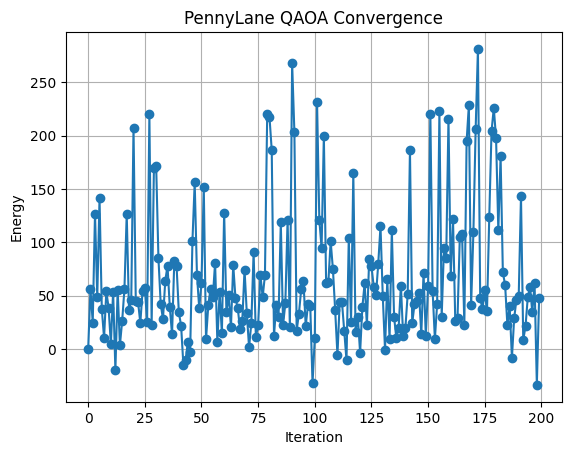

In [ ]:
# =====================================================================
#  RANK-BASED ISING — QAOA Implementation using PennyLane
#  Fully Modular - Research Grade - Clean
# =====================================================================

import pennylane as qml
from pennylane import numpy as np
import itertools
import matplotlib.pyplot as plt


# ================================================================
# 1) Classical brute-force ground state (for verification)
# ================================================================

def classical_ground_state(N, d):
    best_E = 1e99
    best_s = None

    for config in itertools.product([1, -1], repeat=N):
        E = 0
        for i in range(N):
            for j in range(i+1, N):
                Jij = (i+1)**d + (j+1)**d
                E += Jij * config[i] * config[j]

        if E < best_E:
            best_E = E
            best_s = config

    return best_E, best_s


# ================================================================
# 2) Build cost Hamiltonian for PennyLane
# ================================================================

def build_cost_hamiltonian(N, d):
    coeffs = []
    ops = []

    for i in range(N):
        for j in range(i+1, N):
            Jij = (i+1)**d + (j+1)**d
            coeffs.append(Jij)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)


# ================================================================
# 3) QAOA Ansatz (advanced custom version)
# ================================================================

def qaoa_layer(gamma, beta, H, N):
    """One layer of QAOA."""
    # Cost: exp(-i γ H_C)
    qml.templates.ApproxTimeEvolution(H, gamma, 1)

    # Mixer: RX rotations
    for i in range(N):
        qml.RX(2 * beta, wires=i)


# ================================================================
# 4) Build full QAOA Circuit
# ================================================================

def build_qaoa_circuit(N, p, H):

    @qml.qnode(qml.device("default.qubit", wires=N), interface="autograd")
    def circuit(params):
        # params contains [gamma_0 ... gamma_p-1, beta_0 ... beta_p-1]
        gammas = params[:p]
        betas = params[p:]

        # Start in |+...+>
        for i in range(N):
            qml.Hadamard(i)

        # Apply layers
        for layer in range(p):
            qaoa_layer(gammas[layer], betas[layer], H, N)

        return qml.expval(H)

    return circuit


# ================================================================
# 5) Run QAOA optimization
# ================================================================

def run_qaoa(N, d, p, max_iter=200):

    print(f"\n🔥 Running QAOA on PennyLane — N={N}, d={d}, p={p}")

    # Classical solution
    classical_E, classical_s = classical_ground_state(N, d)
    print(f"• Classical ground energy: {classical_E}")
    print(f"• Classical ground config: {classical_s}\n")

    # Build quantum Hamiltonian
    H = build_cost_hamiltonian(N, d)

    # Build QAOA circuit
    qaoa = build_qaoa_circuit(N, p, H)

    # Initialize parameters
    params = np.random.uniform(0, np.pi, size=2*p)
    opt = qml.GradientDescentOptimizer(stepsize=0.1)

    history = []

    for it in range(max_iter):
        params, energy = opt.step_and_cost(qaoa, params)
        history.append(energy)
        if it % 20 == 0:
            print(f"Iter {it:3d} — Energy = {energy:.6f}")

    print(f"\n🎯 Final optimized energy: {energy}")
    print(f"🎯 Classical benchmark:    {classical_E}")

    return params, history, classical_E, classical_s, H, qaoa


# ================================================================
# Run Example
# ================================================================

if __name__ == "__main__":
    N = 12
    d = 1.5
    p = 3

    params, history, classical_E, classical_s, H, qaoa = run_qaoa(N, d, p)

    # Plot convergence
    plt.plot(history, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.title("PennyLane QAOA Convergence")
    plt.show()


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Building J and classical solution...
Classical ground energy: -566.0890728989674
Classical ground config: [ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.]
it    0  E=-558.04170898  overlap=0.000000  lr=0.01250  avgS=0.0000
it   10  E=-565.06399135  overlap=0.000000  lr=0.11642  avgS=0.0000
it   20  E=-555.78667826  overlap=0.000000  lr=1.00000  avgS=0.0136
it   30  E=-258.73494403  overlap=0.000000  lr=1.00000  avgS=0.0031
it   40  E=-484.38828223  overlap=0.000000  lr=1.00000  avgS=0.0259
it   50  E=-545.97649927  overlap=0.000000  lr=1.00000  avgS=0.0585
it   60  E=-556.98690378  overlap=0.000000  lr=1.00000  avgS=0.0136
[it=62] stagnation detected: reduce lr -> 5.000e-01, perturb params
it   70  E=-560.03832382  overlap=0.000000  lr=1.00000  avgS=0.0249
it   80  E=-559.09502787  overlap=0.000000  lr=1.00000  avgS=0.0028
it   90  E=-544.81960471  overlap=0.000000  lr=1.00000  avgS=0.0000
it   99  E=-555.69640389  overlap=0.000000  lr=1.00000  avgS=0.0005
Training done. Time (s):

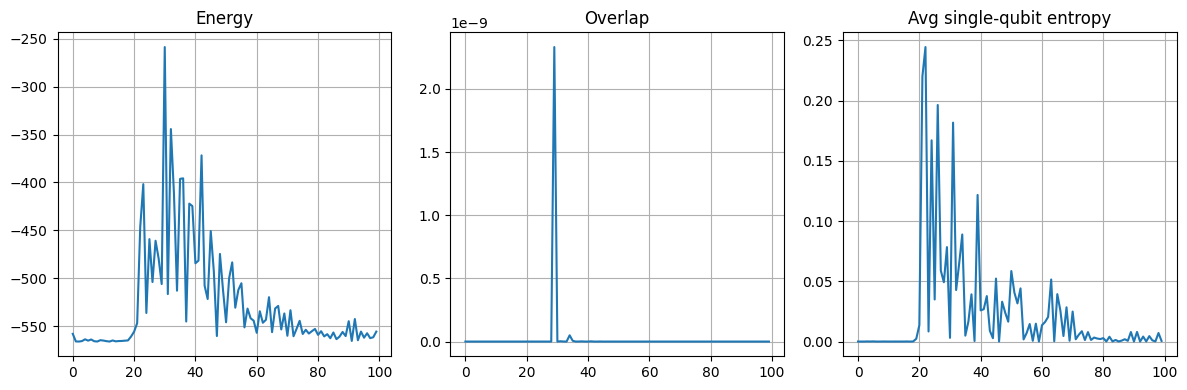

In [ ]:
# final_level2_pennylane_torch_qaoa_fixed.py
# PennyLane + Torch QAOA (Level-2 dynamic LR guided by overlap)
# Warm-start from classical solution. Measures overlap + entanglement.
# Saves best params and history to JSON.

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools, time, json, os
import matplotlib.pyplot as plt

# ---------------- User parameters ----------------
N = 13      # start with 6-8; increase to 12 when ready
d = 1.5
p = 3         # QAOA depth (p >= 2 recommended)
max_iters = 100
patience = 60
save_dir = "./qaoa_level2_torch"
os.makedirs(save_dir, exist_ok=True)
device_name = "default.qubit"  # or "lightning.qubit" if installed

# ---------------- Build J (exact same classical model) ----------------
def build_J(N, d):
    J = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i+1, N):
            J[i, j] = (i+1)**d + (j+1)**d
            J[j, i] = J[i, j]
    return J

# ---------------- Classical brute force ground state ----------------
def classical_ground_state(N, d):
    best_E = np.inf
    best_config = None
    for config in itertools.product([1, -1], repeat=N):
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * config[i] * config[j]
        if E < best_E:
            best_E = E
            best_config = np.array(config, dtype=float)  # float for Torch interface
    return best_E, best_config

# ---------------- Build PennyLane Hamiltonian (for expectation) ----------------
def build_hamiltonian_from_J(J):
    coeffs = []
    ops = []
    Nloc = J.shape[0]
    for i in range(Nloc):
        for j in range(i+1, Nloc):
            coeffs.append(float(J[i, j]))   # plain Python float
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    H = qml.Hamiltonian(coeffs, ops)
    return H

# ---------------- QNode device + helpers ----------------
dev = qml.device(device_name, wires=N)

def prepare_classical_state(s):
    # s is sequence of +1/-1 (torch or numpy), but should be non-trainable (constants)
    for i, val in enumerate(s):
        # cast val to float (safe because s is not trainable)
        if float(val) < 0:
            qml.PauliX(wires=i)

def qaoa_cost_layer(gamma, J):
    # apply e^{-i * gamma * sum_{i<j} J_ij Z_i Z_j}
    # IsingZZ uses parameter phi with exp(-i * phi/2 * Z_i Z_j)
    # so phi/2 = gamma * J_ij  => phi = 2 * gamma * J_ij
    Nloc = J.shape[0]
    for i in range(Nloc):
        for j in range(i+1, Nloc):
            # gamma is a torch scalar (possibly requires_grad), J[i,j] is float
            theta = 2.0 * gamma * float(J[i, j])
            qml.IsingZZ(theta, wires=[i, j])

def qaoa_mixer_layer(beta):
    for i in range(N):
        qml.RX(2.0 * beta, wires=i)

# Pre-build Hamiltonian (global)
# Use Python floats in H so PennyLane treats it as constant operator
# We'll not recreate H inside QNode to avoid mixing frameworks inside the node.
# H used only with qml.expval(H) which references the prebuilt operator.
# But because QNode is defined below, H must be defined before QNode usage.
# We'll set H later after constructing J.

# QNode returning expectation of H (torch scalar)
@qml.qnode(dev, interface="torch")
def qnode_energy(params, s_init, J):
    # params: torch tensor length 2*p: [gamma0.., beta0..]
    gammas = params[:p]   # torch tensor slice
    betas  = params[p:]   # torch tensor slice
    # prepare warm-start classical state (s_init is torch tensor or numpy arr, constant)
    prepare_classical_state(s_init)
    # layers
    for k in range(p):
        qaoa_cost_layer(gammas[k], J)
        qaoa_mixer_layer(betas[k])
    # expectation of H (we assume H is available in closure)
    return qml.expval(H_global)

# QNode returning statevector and probs for diagnostics
@qml.qnode(dev, interface="torch")
def qnode_state_and_probs(params, s_init, J):
    gammas = params[:p]
    betas  = params[p:]
    prepare_classical_state(s_init)
    for k in range(p):
        qaoa_cost_layer(gammas[k], J)
        qaoa_mixer_layer(betas[k])
    return qml.state(), qml.probs(wires=range(N))

# ---------------- overlap helper ----------------
def s_to_index(s):
    # s: numpy array +1/-1, map +1 -> 0, -1 -> 1; MSB: wire 0 leftmost -> reverse
    bits = [0 if int(x) == 1 else 1 for x in s[::-1]]
    idx = 0
    for b in bits:
        idx = (idx << 1) | b
    return idx

def compute_overlap_from_probs(probs_torch, s_idx):
    return float(probs_torch[s_idx].item())

# ---------------- entanglement measure: single-qubit von Neumann entropy ----------------
def single_qubit_entropy_from_state(state_np, qubit, N):
    psi = state_np.reshape((-1,1))
    rho = psi @ psi.conj().T  # full density matrix
    # partial trace to get 2x2 reduced density for 'qubit'
    def partial_trace(mat, keep, N):
        resh = mat.reshape([2]*(2*N))
        keep_axes = keep
        trace_axes = [i for i in range(N) if i not in keep_axes]
        axes = keep_axes + trace_axes + [i+N for i in keep_axes] + [i+N for i in trace_axes]
        trans = np.transpose(resh, axes)
        k = len(keep_axes)
        kept_dim = 2**k
        traced_dim = 2**(N-k)
        new_shape = (kept_dim, traced_dim, kept_dim, traced_dim)
        mat2 = trans.reshape(new_shape)
        res = np.zeros((kept_dim, kept_dim), dtype=complex)
        for a in range(traced_dim):
            res += mat2[:, a, :, a]
        return res
    rho_red = partial_trace(rho, [qubit], N)
    eigs = np.linalg.eigvalsh(rho_red)
    eigs = np.clip(eigs.real, 0, 1)
    eps = 1e-12
    s = -np.sum(eigs * np.log2(eigs + eps))
    return float(s)

# ---------------- dynamic LR rule ----------------
def update_lr(lr, p_star):
    if p_star < 0.01:
        lr *= 1.25
    elif p_star < 0.1:
        lr *= 1.05
    elif p_star < 0.5:
        lr *= 0.95
    else:
        lr *= 0.8
    lr = min(max(lr, 1e-6), 1.0)
    return lr

# ---------------- Main training pipeline ----------------
def train_level2_torch(N, d, p, max_iters=400, patience=60, lr0=1e-2):
    global H_global
    print("Building J and classical solution...")
    J = build_J(N, d)
    E_classical, s_star = classical_ground_state(N, d)
    print("Classical ground energy:", E_classical)
    print("Classical ground config:", s_star)

    # Build global Hamiltonian with python floats (no torch/autograd)
    H_global = build_hamiltonian_from_J(J)

    s_idx = s_to_index(s_star)

    # initial params warm-start (torch param)
    Jmax = np.max(np.abs(J))
    gamma0 = 0.05 / (Jmax if Jmax > 0 else 1.0)
    beta0 = 0.02
    init = np.array([gamma0]*p + [beta0]*p, dtype=float)
    params = torch.tensor(init, dtype=torch.float64, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr0)

    lr = lr0
    best = {"energy": float("inf"), "params": None, "overlap": 0.0, "entropy": None}
    history = []
    no_improve = 0
    t0 = time.time()

    # Convert s_star to torch tensor constant to pass to QNode (non-trainable)
    s_star_torch = torch.tensor(s_star, dtype=torch.float64)

    for it in range(max_iters):
        optimizer.zero_grad()
        # forward: energy (torch scalar)
        energy_t = qnode_energy(params, s_star_torch, J)
        loss = energy_t
        # backprop
        loss.backward()
        optimizer.step()

        # readjust lr by overlap guidance AFTER step
        state_t, probs_t = qnode_state_and_probs(params, s_star_torch, J)
        overlap = compute_overlap_from_probs(probs_t, s_idx)
        lr = update_lr(lr, overlap)
        for g in optimizer.param_groups:
            g['lr'] = lr

        # compute entanglement measures from state (convert to numpy)
        state_np = state_t.detach().cpu().numpy()
        entropies = [single_qubit_entropy_from_state(state_np, q, N) for q in range(N)]
        avg_entropy = float(np.mean(entropies))

        energy_val = float(energy_t.detach().item())

        history.append({"iter": it, "energy": energy_val, "overlap": overlap, "lr": lr, "avg_entropy": avg_entropy})

        # track best by energy (then by overlap)
        if energy_val < best["energy"] - 1e-12 or (abs(energy_val - best["energy"]) < 1e-12 and overlap > best["overlap"]):
            best.update({"energy": energy_val, "params": params.clone().detach().cpu().numpy().tolist(), "overlap": overlap, "entropy": avg_entropy})
            no_improve = 0
        else:
            no_improve += 1

        if it % 10 == 0 or it == max_iters-1:
            print(f"it {it:4d}  E={energy_val:.8f}  overlap={overlap:.6f}  lr={lr:.5f}  avgS={avg_entropy:.4f}")

        # stagnation handling
        if no_improve >= patience:
            lr *= 0.5
            for g in optimizer.param_groups:
                g['lr'] = lr
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_improve = 0
            print(f"[it={it}] stagnation detected: reduce lr -> {lr:.3e}, perturb params")

        # early stopping if match classical energy
        if abs(energy_val - E_classical) < 1e-8:
            print(f"Converged to classical energy at iteration {it}")
            break

    t1 = time.time()
    print("Training done. Time (s):", t1 - t0)

    out = {
        "N": N, "d": d, "p": p, "classical_energy": float(E_classical),
        "classical_config": s_star.tolist(),
        "best": best,
        "history": history
    }

    fname = os.path.join(save_dir, f"level2_torch_N{N}_d{d}_p{p}.json")
    with open(fname, "w") as f:
        json.dump(out, f, indent=2)
    print("Saved run to", fname)
    return out

# ---------------- Run training ----------------
if __name__ == "__main__":
    res = train_level2_torch(N, d, p, max_iters=max_iters, patience=patience, lr0=1e-2)
    # quick plots
    hist = res["history"]
    its = [h["iter"] for h in hist]
    Es = [h["energy"] for h in hist]
    Ovs = [h["overlap"] for h in hist]
    Ss = [h["avg_entropy"] for h in hist]
    LRs = [h["lr"] for h in hist]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(its, Es); plt.title("Energy"); plt.grid(True)
    plt.subplot(1,3,2); plt.plot(its, Ovs); plt.title("Overlap"); plt.grid(True)
    plt.subplot(1,3,3); plt.plot(its, Ss); plt.title("Avg single-qubit entropy"); plt.grid(True)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(



=== START RUN 0 (seed=1234) ===
[run 1234] it    0  E=-137.34627458  ov=0.000000  lr=0.0125  avgS=0.0000
[run 1234] it   10  E=-138.86205312  ov=0.000000  lr=0.1164  avgS=0.0000
[run 1234] it   20  E=-68.70927673  ov=0.000079  lr=1.0000  avgS=0.4356
[run 1234] it   30  E=-99.22461185  ov=0.000000  lr=1.0000  avgS=0.1042
[run 1234] it   40  E=-1.35782777  ov=0.000107  lr=1.0000  avgS=0.5175
[run 1234] it   50  E=-84.91630045  ov=0.000000  lr=1.0000  avgS=0.2234
[run 1234] it   60  E=-105.66676420  ov=0.000000  lr=1.0000  avgS=0.0571
[run 1234] stagnation -> reduce lr to 5.000e-01, perturb params
[run 1234] it   70  E=-133.75911519  ov=0.000000  lr=1.0000  avgS=0.0088
[run 1234] it   80  E=-124.98797801  ov=0.000001  lr=1.0000  avgS=0.1731
[run 1234] it   90  E=-127.81564970  ov=0.000000  lr=1.0000  avgS=0.1612
[run 1234] it  100  E=-132.91960597  ov=0.000000  lr=1.0000  avgS=0.1012
[run 1234] it  110  E=-11.52629868  ov=0.000239  lr=1.0000  avgS=0.5954
[run 1234] it  120  E=-25.3210231

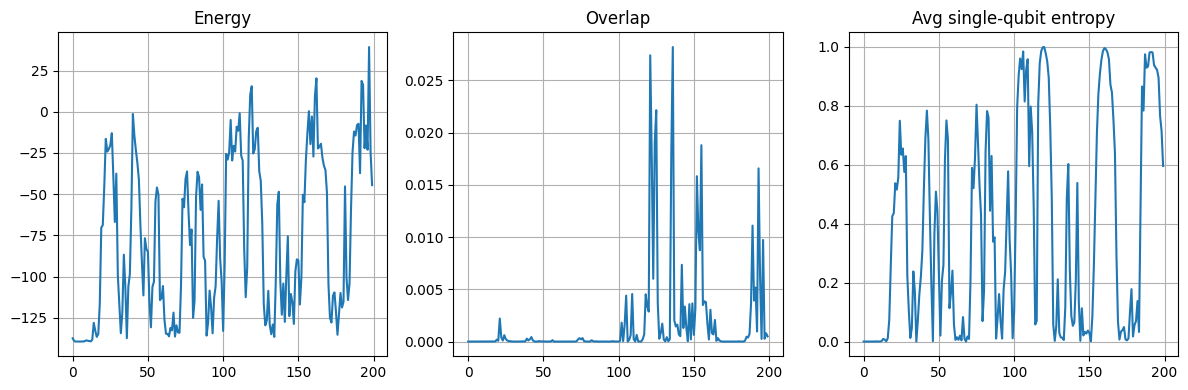

In [ ]:
# improved_level2_pennylane_torch_qaoa.py
# Improved, robust version of Level-2 QAOA training (PennyLane + Torch).
# Features:
#  - precomputed edge list for faster IsingZZ loops
#  - start modes: "classical", "plus", "blended"
#  - multi-restarts, checkpointing, best params saved to .json and .pt
#  - gradient clipping, lr scheduling, perturbation on stagnation
#  - optional lightning backend if available
#  - careful type handling (Torch tensors inside QNodes)

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools, time, json, os, math
import matplotlib.pyplot as plt
from typing import List, Tuple

# ---------------- User parameters (tweakable) ----------------
N = 8             # problem size
d = 1.5
p = 3
max_iters = 200
patience = 60
save_dir = "./qaoa_level2_torch_improved"
os.makedirs(save_dir, exist_ok=True)

# training options
lr0 = 1e-2
weight_decay = 0.0
grad_clip = 1.0
num_restarts = 3          # run several restarts (keeps best)
seed = 1234

# start mode: "classical" | "plus" | "blended"
start_mode = "classical"
blended_eps = 0.2         # used only if start_mode == "blended"

# device selection
use_lightning = False     # set True if pennylane-lightning is installed
device_name = "lightning.qubit" if use_lightning else "default.qubit"

# safety: don't brute force if N too large
BRUTE_FORCE_LIMIT = 16    # 2^16 states => 65536 (may be slow)

# ---------------- Utility: Build J and edge list ----------------
def build_J_and_edges(N: int, d: float) -> Tuple[np.ndarray, List[Tuple[int,int]], List[float]]:
    J = np.zeros((N,N), dtype=float)
    edges = []
    weights = []
    for i in range(N):
        for j in range(i+1, N):
            Jij = (i+1)**d + (j+1)**d
            J[i,j] = Jij
            J[j,i] = Jij
            edges.append((i,j))
            weights.append(float(Jij))
    return J, edges, weights

# ---------------- Classical brute-force ground state (if feasible) ----------------
def classical_ground_state(N: int, d: float):
    if N > BRUTE_FORCE_LIMIT:
        raise RuntimeError(f"Brute force disabled for N>{BRUTE_FORCE_LIMIT}. Set smaller N or compute approx.")
    best_E = np.inf
    best_config = None
    for config in itertools.product([1,-1], repeat=N):
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * config[i] * config[j]
        if E < best_E:
            best_E = E
            best_config = np.array(config, dtype=float)
    return best_E, best_config

# ---------------- PennyLane qnode device ----------------
dev = qml.device(device_name, wires=N)

# ---------------- Prepare start states ----------------
def prepare_classical_state(s):
    # s: array-like +1/-1 (non-trainable)
    for i, val in enumerate(s):
        if float(val) < 0:
            qml.PauliX(wires=i)

def prepare_plus_state(N):
    for i in range(N):
        qml.Hadamard(wires=i)

def prepare_blended_state(s, eps: float):
    # |psi0> = cos(eps)|+> + sin(eps)|s>
    # implement as: start |+>, then controlled rotations to increase amplitude on s
    # practical simple construction: start as |+> then apply biased X rotations towards s
    for i in range(N):
        qml.Hadamard(wires=i)
    # apply small Z-rotations controlled by s to bias - this is a heuristic
    for i, val in enumerate(s):
        if float(val) < 0:
            qml.RZ(2.0 * eps, wires=i)  # small phase to bias amplitude (heuristic)

# ---------------- cost & mixer layers using precomputed edges ----------------
def qaoa_cost_layer_edges(gamma, edges, weights):
    # gamma: Torch scalar (tracked), weights: python floats
    for (i,j), w in zip(edges, weights):
        theta = 2.0 * gamma * float(w)
        qml.IsingZZ(theta, wires=[i,j])

def qaoa_mixer_layer(beta):
    for i in range(N):
        qml.RX(2.0 * beta, wires=i)

# ---------------- build global Hamiltonian operator once ----------------
def build_hamiltonian_from_edges(edges, weights):
    coeffs = [float(w) for w in weights]
    ops = [qml.PauliZ(i) @ qml.PauliZ(j) for (i,j) in edges]
    return qml.Hamiltonian(coeffs, ops)

# ---------------- QNodes (Torch interface) ----------------
@qml.qnode(dev, interface="torch")
def qnode_energy(params, s_init, edges, weights, H):
    gammas = params[:p]
    betas  = params[p:]
    # prepare start state according to mode
    if start_mode == "classical":
        prepare_classical_state(s_init)
    elif start_mode == "plus":
        prepare_plus_state(N)
    elif start_mode == "blended":
        prepare_blended_state(s_init, blended_eps)
    else:
        raise ValueError("Unknown start_mode")

    for k in range(p):
        qaoa_cost_layer_edges(gammas[k], edges, weights)
        qaoa_mixer_layer(betas[k])
    return qml.expval(H)

@qml.qnode(dev, interface="torch")
def qnode_state_and_probs(params, s_init, edges, weights, H):
    gammas = params[:p]
    betas  = params[p:]
    if start_mode == "classical":
        prepare_classical_state(s_init)
    elif start_mode == "plus":
        prepare_plus_state(N)
    elif start_mode == "blended":
        prepare_blended_state(s_init, blended_eps)
    for k in range(p):
        qaoa_cost_layer_edges(gammas[k], edges, weights)
        qaoa_mixer_layer(betas[k])
    return qml.state(), qml.probs(wires=range(N))

# ---------------- helpers ----------------
def s_to_index(s):
    bits = [0 if int(x)==1 else 1 for x in s[::-1]]
    idx = 0
    for b in bits:
        idx = (idx<<1) | b
    return idx

def compute_overlap_from_probs(probs_torch, s_idx):
    return float(probs_torch[s_idx].item())

def single_qubit_entropy_from_state(state_np, qubit_index, N):
    psi = state_np.reshape((-1,1))
    rho = psi @ psi.conj().T
    def partial_trace(mat, keep, N):
        resh = mat.reshape([2]*(2*N))
        keep_axes = keep
        trace_axes = [i for i in range(N) if i not in keep_axes]
        axes = keep_axes + trace_axes + [i+N for i in keep_axes] + [i+N for i in trace_axes]
        trans = np.transpose(resh, axes)
        k = len(keep_axes)
        kept_dim = 2**k
        traced_dim = 2**(N-k)
        new_shape = (kept_dim, traced_dim, kept_dim, traced_dim)
        mat2 = trans.reshape(new_shape)
        res = np.zeros((kept_dim, kept_dim), dtype=complex)
        for a in range(traced_dim):
            res += mat2[:, a, :, a]
        return res
    rho_red = partial_trace(rho, [qubit_index], N)
    eigs = np.linalg.eigvalsh(rho_red)
    eigs = np.clip(eigs.real, 0, 1)
    eps = 1e-12
    s = -np.sum(eigs * np.log2(eigs + eps))
    return float(s)

def update_lr(lr, overlap):
    if overlap < 0.01:
        lr *= 1.25
    elif overlap < 0.1:
        lr *= 1.05
    elif overlap < 0.5:
        lr *= 0.95
    else:
        lr *= 0.8
    return min(max(lr, 1e-6), 1.0)

# ---------------- training routine (single run) ----------------
def run_one_training(seed_run: int = 0):
    torch.manual_seed(seed_run)
    np.random.seed(seed_run)

    J, edges, weights = build_J_and_edges(N, d)
    # classical solution if feasible
    try:
        E_classical, s_star = classical_ground_state(N, d)
    except RuntimeError:
        E_classical, s_star = None, None
    if s_star is not None:
        s_idx = s_to_index(s_star)
    else:
        s_idx = None

    H = build_hamiltonian_from_edges(edges, weights)

    # initial params warm-start
    Jmax = np.max(np.abs(J))
    gamma0 = 0.05 / (Jmax if Jmax>0 else 1.0)
    beta0 = 0.02
    init = np.array([gamma0]*p + [beta0]*p, dtype=float)
    params = torch.tensor(init, dtype=torch.float64, requires_grad=True)

    optimizer = torch.optim.Adam([params], lr=lr0, weight_decay=weight_decay)
    lr = lr0

    best = {"energy": float("inf"), "overlap": 0.0, "entropy": None, "params": None}
    history = []
    no_improve = 0

    # prepare s_star torch if exists
    if s_star is not None:
        s_star_torch = torch.tensor(s_star, dtype=torch.float64)
    else:
        s_star_torch = None

    t0 = time.time()
    for it in range(max_iters):
        optimizer.zero_grad()
        energy_t = qnode_energy(params, s_star_torch if s_star_torch is not None else torch.zeros(N), edges, weights, H)
        loss = energy_t
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_([params], grad_clip)

        optimizer.step()

        # diagnostics (state & probs)
        state_t, probs_t = qnode_state_and_probs(params, s_star_torch if s_star_torch is not None else torch.zeros(N), edges, weights, H)
        overlap = compute_overlap_from_probs(probs_t, s_idx) if s_idx is not None else 0.0

        # update lr (guidance)
        lr = update_lr(lr, overlap)
        for g in optimizer.param_groups:
            g['lr'] = lr

        # entanglement
        state_np = state_t.detach().cpu().numpy()
        entropies = [single_qubit_entropy_from_state(state_np, q, N) for q in range(N)]
        avg_entropy = float(np.mean(entropies))

        energy_val = float(energy_t.detach().item())
        history.append({"iter": it, "energy": energy_val, "overlap": overlap, "lr": lr, "avg_entropy": avg_entropy})

        improved = False
        if energy_val < best["energy"] - 1e-12 or (abs(energy_val - best["energy"]) < 1e-12 and overlap > best["overlap"]):
            # update best
            best["energy"] = energy_val
            best["overlap"] = overlap
            best["entropy"] = avg_entropy
            best["params"] = params.clone().detach().cpu().numpy().tolist()
            improved = True
            no_improve = 0
        else:
            no_improve += 1

        if it % 10 == 0:
            print(f"[run {seed_run}] it {it:4d}  E={energy_val:.8f}  ov={overlap:.6f}  lr={lr:.4f}  avgS={avg_entropy:.4f}")

        if no_improve >= patience:
            # stagnation: reduce lr and small perturbation
            lr *= 0.5
            for g in optimizer.param_groups:
                g['lr'] = lr
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_improve = 0
            print(f"[run {seed_run}] stagnation -> reduce lr to {lr:.3e}, perturb params")

        if E_classical is not None and abs(energy_val - E_classical) < 1e-9:
            print(f"[run {seed_run}] converged to classical energy at iter {it}")
            break

    t1 = time.time()
    elapsed = t1 - t0
    return {"best": best, "history": history, "elapsed_s": elapsed, "J": J.tolist(), "edges": edges, "weights": weights, "classical_energy": E_classical, "classical_config": s_star.tolist() if s_star is not None else None}

# ---------------- multi-restart manager ----------------
def run_with_restarts():
    runs = []
    global_best = None
    for r in range(num_restarts):
        seed_run = seed + r*13
        print(f"\n=== START RUN {r} (seed={seed_run}) ===")
        res = run_one_training(seed_run)
        runs.append(res)
        b = res["best"]
        if global_best is None or b["energy"] < global_best["best"]["energy"] - 1e-12:
            global_best = {"run_index": r, "best": b, "res": res}
    # save combined JSON
    out = {"meta": {"N": N, "d": d, "p": p, "max_iters": max_iters, "patience": patience, "num_restarts": num_restarts, "start_mode": start_mode, "blended_eps": blended_eps},
           "global_best": global_best,
           "runs": runs}
    fname = os.path.join(save_dir, f"level2_runs_N{N}_d{d}_p{p}.json")
    with open(fname, "w") as f:
        json.dump(out, f, indent=2)
    print("\nSaved all runs to", fname)

    # also save best params as .pt for easy loading into PyTorch
    gb = global_best["best"]
    params_np = np.array(gb["params"])
    pt_fname = os.path.join(save_dir, f"best_params_N{N}_d{d}_p{p}.pt")
    torch.save(torch.tensor(params_np), pt_fname)
    print("Saved best params .pt ->", pt_fname)

    # print summary
    print("\n=== GLOBAL BEST SUMMARY ===")
    print("run index:", global_best["run_index"])
    print("energy:", gb["energy"])
    print("overlap:", gb["overlap"])
    print("avg_entropy:", gb["entropy"])
    print("params (gamma):", params_np[:p].tolist())
    print("params (beta):", params_np[p:].tolist())

    return out

# ---------------- main ----------------
if __name__ == "__main__":
    final_out = run_with_restarts()

    # quick plots using best run's history (take global_best run)
    best_history = final_out["runs"][final_out["global_best"]["run_index"]]["history"]
    its = [h["iter"] for h in best_history]
    Es = [h["energy"] for h in best_history]
    Ovs = [h["overlap"] for h in best_history]
    Ss = [h["avg_entropy"] for h in best_history]
    LRs = [h["lr"] for h in best_history]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(its, Es); plt.title("Energy"); plt.grid(True)
    plt.subplot(1,3,2); plt.plot(its, Ovs); plt.title("Overlap"); plt.grid(True)
    plt.subplot(1,3,3); plt.plot(its, Ss); plt.title("Avg single-qubit entropy"); plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install qiskit.algorithms.optimizers

ERROR: Could not find a version that satisfies the requirement qiskit.algorithms.optimizers (from versions: none)
ERROR: No matching distribution found for qiskit.algorithms.optimizers


In [ ]:
# qaoa_pennylane_simulation.py
# PennyLane + Torch QAOA (simulation-only)
# - Warm-start options: classical | plus | blended
# - Brute-force ground state (if N <= BRUTE_FORCE_LIMIT)
# - Manual training loop with Adam, gradient clipping, adaptive lr by overlap
# - Returns and saves best params, history, and simple plots
# - Clean, hardware-free (no Estimator/Sampler/Runtime calls)
# Author: Assistant (tailored)

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools, time, json, os, math
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict

# ---------------- User parameters (tweakable) ----------------
N = 8              # problem size; set <= BRUTE_FORCE_LIMIT to enable brute-force
d = 1.5
p = 3
max_iters = 200
patience = 60
save_dir = "./qaoa_level2_torch_improved_sim"
os.makedirs(save_dir, exist_ok=True)

# training options
lr0 = 1e-2
weight_decay = 0.0
grad_clip = 1.0
num_restarts = 2          # run several restarts (keeps best)
seed = 1234

# start mode: "classical" | "plus" | "blended"
start_mode = "classical"
blended_eps = 0.2         # used only if start_mode == "blended"

# device selection
use_lightning = False     # set True if pennylane-lightning is installed
device_name = "lightning.qubit" if use_lightning else "default.qubit"

# safety: don't brute force if N too large
BRUTE_FORCE_LIMIT = 16    # 2^16 = 65536 states (can be slow)

# numerical dtype
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)

# ---------------- Utility: Build J and edge list ----------------
def build_J_and_edges(N: int, d: float) -> Tuple[np.ndarray, List[Tuple[int,int]], List[float]]:
    J = np.zeros((N,N), dtype=float)
    edges = []
    weights = []
    for i in range(N):
        for j in range(i+1, N):
            Jij = (i+1)**d + (j+1)**d
            J[i,j] = Jij
            J[j,i] = Jij
            edges.append((i,j))
            weights.append(float(Jij))
    return J, edges, weights

# ---------------- Classical brute-force ground state (if feasible) ----------------
def classical_ground_state(N: int, d: float, limit: int = BRUTE_FORCE_LIMIT) -> Tuple[Optional[float], Optional[np.ndarray]]:
    if N > limit:
        return None, None
    best_E = float("inf")
    best_config = None
    # enumerate all 2^N configurations
    for bits in itertools.product([1, -1], repeat=N):
        s = np.array(bits, dtype=float)
        # energy H = sum_{i<j} J_ij s_i s_j
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * s[i] * s[j]
        if E < best_E:
            best_E = E
            best_config = s.copy()
    return float(best_E), best_config

# ---------------- PennyLane qnode device (simulation only) ----------------
try:
    dev = qml.device(device_name, wires=N)
except Exception as e:
    # fallback to default.qubit if desired device missing
    print(f"[Warning] failed to create device '{device_name}': {e}. Falling back to default.qubit.")
    dev = qml.device("default.qubit", wires=N)

# ---------------- Prepare start states ----------------
def prepare_classical_state(s: np.ndarray):
    """Prepare computational-basis product state |s> where s_i in {+1,-1}."""
    for i, val in enumerate(s):
        if float(val) < 0:
            qml.PauliX(wires=i)

def prepare_plus_state(N_local: int):
    """Prepare |+>^{\otimes N}."""
    for i in range(N_local):
        qml.Hadamard(wires=i)

def prepare_blended_state(s: np.ndarray, eps: float):
    """
    Heuristic blended start: start from |+> and introduce small Z phases depending on s.
    This is not exact amplitude engineering but biases the initial state toward s.
    """
    for i in range(len(s)):
        qml.Hadamard(wires=i)
    # small Z rotation conditional on s sign (heuristic bias)
    for i, val in enumerate(s):
        if float(val) < 0:
            qml.RZ(2.0 * eps, wires=i)

# ---------------- cost & mixer layers using precomputed edges ----------------
def qaoa_cost_layer_edges(gamma, edges: List[Tuple[int,int]], weights: List[float]):
    # gamma: Torch scalar (tracked), weights: python floats
    for (i, j), w in zip(edges, weights):
        theta = 2.0 * gamma * float(w)
        qml.IsingZZ(theta, wires=[i, j])

def qaoa_mixer_layer(beta):
    for i in range(N):
        qml.RX(2.0 * beta, wires=i)

# ---------------- build global Hamiltonian operator once ----------------
def build_hamiltonian_from_edges(edges: List[Tuple[int,int]], weights: List[float]) -> qml.Hamiltonian:
    coeffs = [float(w) for w in weights]
    ops = [qml.PauliZ(i) @ qml.PauliZ(j) for (i, j) in edges]
    return qml.Hamiltonian(coeffs, ops)

# ---------------- QNodes (Torch interface) ----------------
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnode_energy(params, s_init, edges, weights, H):
    # params: torch tensor shape (2*p,)
    gammas = params[:p]
    betas  = params[p:]
    # start state according to selected mode
    if start_mode == "classical":
        prepare_classical_state(s_init)
    elif start_mode == "plus":
        prepare_plus_state(N)
    elif start_mode == "blended":
        prepare_blended_state(s_init, blended_eps)
    else:
        raise ValueError("Unknown start_mode")

    for k in range(p):
        qaoa_cost_layer_edges(gammas[k], edges, weights)
        qaoa_mixer_layer(betas[k])
    return qml.expval(H)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnode_state_and_probs(params, s_init, edges, weights, H):
    gammas = params[:p]
    betas  = params[p:]
    if start_mode == "classical":
        prepare_classical_state(s_init)
    elif start_mode == "plus":
        prepare_plus_state(N)
    elif start_mode == "blended":
        prepare_blended_state(s_init, blended_eps)
    for k in range(p):
        qaoa_cost_layer_edges(gammas[k], edges, weights)
        qaoa_mixer_layer(betas[k])
    # return statevector (complex) and probability vector
    return qml.state(), qml.probs(wires=range(N))

# ---------------- helpers ----------------
def s_to_index(s: np.ndarray) -> int:
    bits = [0 if int(x)==1 else 1 for x in s[::-1]]  # little-endian mapping
    idx = 0
    for b in bits:
        idx = (idx<<1) | b
    return idx

def compute_overlap_from_probs(probs_torch, s_idx: int) -> float:
    # probs_torch is a torch tensor of shape (2**N,)
    return float(probs_torch[s_idx].item())

def single_qubit_entropy_from_state(state_np: np.ndarray, qubit_index: int, N_local: int) -> float:
    psi = state_np.reshape((-1,1))
    rho = psi @ psi.conj().T
    # partial trace to single qubit
    def partial_trace(mat, keep, Np):
        resh = mat.reshape([2]*(2*Np))
        keep_axes = keep
        trace_axes = [i for i in range(Np) if i not in keep_axes]
        axes = keep_axes + trace_axes + [i+Np for i in keep_axes] + [i+Np for i in trace_axes]
        trans = np.transpose(resh, axes)
        k = len(keep_axes)
        kept_dim = 2**k
        traced_dim = 2**(Np-k)
        new_shape = (kept_dim, traced_dim, kept_dim, traced_dim)
        mat2 = trans.reshape(new_shape)
        res = np.zeros((kept_dim, kept_dim), dtype=complex)
        for a in range(traced_dim):
            res += mat2[:, a, :, a]
        return res
    rho_red = partial_trace(rho, [qubit_index], N_local)
    eigs = np.linalg.eigvalsh(rho_red)
    eigs = np.clip(eigs.real, 0.0, 1.0)
    eps = 1e-12
    s = -np.sum(eigs * np.log2(eigs + eps))
    return float(s)

def update_lr(lr: float, overlap: float) -> float:
    if overlap < 0.01:
        lr *= 1.25
    elif overlap < 0.1:
        lr *= 1.05
    elif overlap < 0.5:
        lr *= 0.95
    else:
        lr *= 0.8
    return min(max(lr, 1e-6), 1.0)

# ---------------- training routine (single run) ----------------
def run_one_training(seed_run: int = 0) -> Dict:
    # set seeds
    torch.manual_seed(seed_run)
    np.random.seed(seed_run)

    J, edges, weights = build_J_and_edges(N, d)
    E_classical, s_star = classical_ground_state(N, d)
    s_idx = s_to_index(s_star) if s_star is not None else None

    H = build_hamiltonian_from_edges(edges, weights)

    # initial params warm-start
    Jmax = np.max(np.abs(J)) if J.size else 1.0
    gamma0 = 0.05 / (Jmax if Jmax>0 else 1.0)
    beta0 = 0.02
    init = np.array([gamma0]*p + [beta0]*p, dtype=float)
    params = torch.tensor(init, dtype=TORCH_DTYPE, requires_grad=True)

    optimizer = torch.optim.Adam([params], lr=lr0, weight_decay=weight_decay)
    lr = lr0

    best = {"energy": float("inf"), "overlap": 0.0, "entropy": None, "params": None}
    history = []
    no_improve = 0

    # prepare s_star torch if exists; else use + state (all +1)
    if s_star is not None:
        s_star_torch = torch.tensor(s_star, dtype=TORCH_DTYPE)
    else:
        s_star_torch = torch.ones(N, dtype=TORCH_DTYPE)

    t0 = time.time()
    for it in range(max_iters):
        optimizer.zero_grad()
        energy_t = qnode_energy(params, s_star_torch, edges, weights, H)
        # energy_t is a torch scalar
        loss = energy_t
        loss.backward()

        # gradient clipping — params is a single tensor, wrap in list
        torch.nn.utils.clip_grad_norm_([params], grad_clip)

        optimizer.step()

        # diagnostics: state & probs (torch tensors)
        state_t, probs_t = qnode_state_and_probs(params, s_star_torch, edges, weights, H)
        # probs_t is a torch tensor of length 2**N
        overlap = compute_overlap_from_probs(probs_t, s_idx) if s_idx is not None else 0.0

        # update lr (guidance)
        lr = update_lr(lr, overlap)
        for g in optimizer.param_groups:
            g['lr'] = lr

        # entanglement (state_t is complex torch tensor)
        state_np = state_t.detach().cpu().numpy()
        entropies = [single_qubit_entropy_from_state(state_np, q, N) for q in range(N)]
        avg_entropy = float(np.mean(entropies))

        energy_val = float(energy_t.detach().item())
        history.append({"iter": it, "energy": energy_val, "overlap": overlap, "lr": lr, "avg_entropy": avg_entropy})

        improved = False
        if energy_val < best["energy"] - 1e-12 or (abs(energy_val - best["energy"]) < 1e-12 and overlap > best["overlap"]):
            # update best
            best["energy"] = energy_val
            best["overlap"] = overlap
            best["entropy"] = avg_entropy
            best["params"] = params.clone().detach().cpu().numpy().tolist()
            improved = True
            no_improve = 0
        else:
            no_improve += 1

        if it % 10 == 0 or it == max_iters - 1:
            print(f"[run {seed_run}] it {it:4d}  E={energy_val:.8f}  ov={overlap:.6f}  lr={lr:.4f}  avgS={avg_entropy:.4f}")

        if no_improve >= patience:
            # stagnation: reduce lr and small perturbation
            lr *= 0.5
            for g in optimizer.param_groups:
                g['lr'] = lr
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_improve = 0
            print(f"[run {seed_run}] stagnation -> reduce lr to {lr:.3e}, perturb params")

        if E_classical is not None and abs(energy_val - E_classical) < 1e-9:
            print(f"[run {seed_run}] converged to classical energy at iter {it}")
            break

    t1 = time.time()
    elapsed = t1 - t0
    return {"best": best, "history": history, "elapsed_s": elapsed, "J": J.tolist(), "edges": edges, "weights": weights, "classical_energy": E_classical, "classical_config": s_star.tolist() if s_star is not None else None}

# ---------------- multi-restart manager ----------------
def run_with_restarts():
    runs = []
    global_best = None
    for r in range(num_restarts):
        seed_run = seed + r*13
        print(f"\n=== START RUN {r} (seed={seed_run}) ===")
        res = run_one_training(seed_run)
        runs.append(res)
        b = res["best"]
        if global_best is None or b["energy"] < global_best["best"]["energy"] - 1e-12:
            global_best = {"run_index": r, "best": b, "res": res}
    # save combined JSON
    out = {"meta": {"N": N, "d": d, "p": p, "max_iters": max_iters, "patience": patience, "num_restarts": num_restarts, "start_mode": start_mode, "blended_eps": blended_eps},
           "global_best": global_best,
           "runs": runs}
    fname = os.path.join(save_dir, f"level2_runs_N{N}_d{d}_p{p}.json")
    with open(fname, "w") as f:
        json.dump(out, f, indent=2)
    print("\nSaved all runs to", fname)

    # also save best params as .pt for easy loading into PyTorch
    gb = global_best["best"]
    if gb["params"] is not None:
        params_np = np.array(gb["params"])
        pt_fname = os.path.join(save_dir, f"best_params_N{N}_d{d}_p{p}.pt")
        torch.save(torch.tensor(params_np, dtype=TORCH_DTYPE), pt_fname)
        print("Saved best params .pt ->", pt_fname)
    else:
        print("No best params to save (None).")

    # print summary
    print("\n=== GLOBAL BEST SUMMARY ===")
    print("run index:", global_best["run_index"])
    print("energy:", gb["energy"])
    print("overlap:", gb["overlap"])
    print("avg_entropy:", gb["entropy"])
    if gb["params"] is not None:
        print("params (gamma):", params_np[:p].tolist())
        print("params (beta):", params_np[p:].tolist())

    return out

# ---------------- main ----------------
if __name__ == "__main__":
    final_out = run_with_restarts()

    # quick plots using best run's history (take global_best run)
    br = final_out["global_best"]
    best_history = br["res"]["history"]
    its = [h["iter"] for h in best_history]
    Es = [h["energy"] for h in best_history]
    Ovs = [h["overlap"] for h in best_history]
    Ss = [h["avg_entropy"] for h in best_history]
    LRs = [h["lr"] for h in best_history]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(its, Es, '-o'); plt.title("Energy"); plt.grid(True)
    plt.subplot(1,3,2); plt.plot(its, Ovs, '-o'); plt.title("Overlap"); plt.grid(True)
    plt.subplot(1,3,3); plt.plot(its, Ss, '-o'); plt.title("Avg single-qubit entropy"); plt.grid(True)
    plt.tight_layout()
    plt.show()


<>:97: SyntaxWarning: invalid escape sequence '\o'
<>:97: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1113310122.py:97: SyntaxWarning: invalid escape sequence '\o'
  """Prepare |+>^{\otimes N}."""



=== START RUN 0 (seed=1234) ===
[run 1234] it    0  E=-137.34627458  ov=0.000000  lr=0.0125  avgS=0.0000
[run 1234] it   10  E=-138.86205312  ov=0.000000  lr=0.1164  avgS=0.0000
[run 1234] it   20  E=-68.70883172  ov=0.000078  lr=1.0000  avgS=0.4358
[run 1234] it   30  E=-127.71400472  ov=0.000001  lr=1.0000  avgS=0.4076
[run 1234] it   40  E=-49.37150380  ov=0.003480  lr=1.0000  avgS=0.7240
[run 1234] it   50  E=-24.03061579  ov=0.006989  lr=1.0000  avgS=0.9893
[run 1234] it   60  E=-98.92537109  ov=0.015086  lr=1.0000  avgS=0.5471
[run 1234] stagnation -> reduce lr to 5.000e-01, perturb params
[run 1234] it   70  E=-102.76817824  ov=0.002361  lr=1.0000  avgS=0.4094
[run 1234] it   80  E=-135.54652224  ov=0.000084  lr=1.0000  avgS=0.0274
[run 1234] it   90  E=-105.20009859  ov=0.000200  lr=1.0000  avgS=0.0256
[run 1234] it  100  E=12.06759282  ov=0.001561  lr=1.0000  avgS=0.9686
[run 1234] it  110  E=-22.31793871  ov=0.002577  lr=1.0000  avgS=0.9514
[run 1234] it  120  E=-12.86117115

KeyboardInterrupt: 


=== START RUN 0 (seed=1234) ===
[run 1234] it    0  E=-137.34627458  ov=0.000000  lr=0.0125  avgS=0.0000
[run 1234] it   10  E=-138.86205312  ov=0.000000  lr=0.1164  avgS=0.0000
[run 1234] it   20  E=-68.70883172  ov=0.000078  lr=1.0000  avgS=0.4358
[run 1234] it   30  E=-127.71400472  ov=0.000001  lr=1.0000  avgS=0.4076
[run 1234] it   40  E=-49.37150380  ov=0.003480  lr=1.0000  avgS=0.7240
[run 1234] it   50  E=-24.03061579  ov=0.006989  lr=1.0000  avgS=0.9893
[run 1234] it   60  E=-98.92537109  ov=0.015086  lr=1.0000  avgS=0.5471
[run 1234] stagnation -> lr 5.000e-01, perturbed params
[run 1234] it   70  E=-102.76817824  ov=0.002361  lr=1.0000  avgS=0.4094
[run 1234] it   80  E=-135.54652224  ov=0.000084  lr=1.0000  avgS=0.0274
[run 1234] it   90  E=-105.20009859  ov=0.000200  lr=1.0000  avgS=0.0256
[run 1234] it  100  E=12.06759282  ov=0.001561  lr=1.0000  avgS=0.9686
[run 1234] it  110  E=-22.31793871  ov=0.002577  lr=1.0000  avgS=0.9514
[run 1234] it  120  E=-12.86117115  ov=0.0

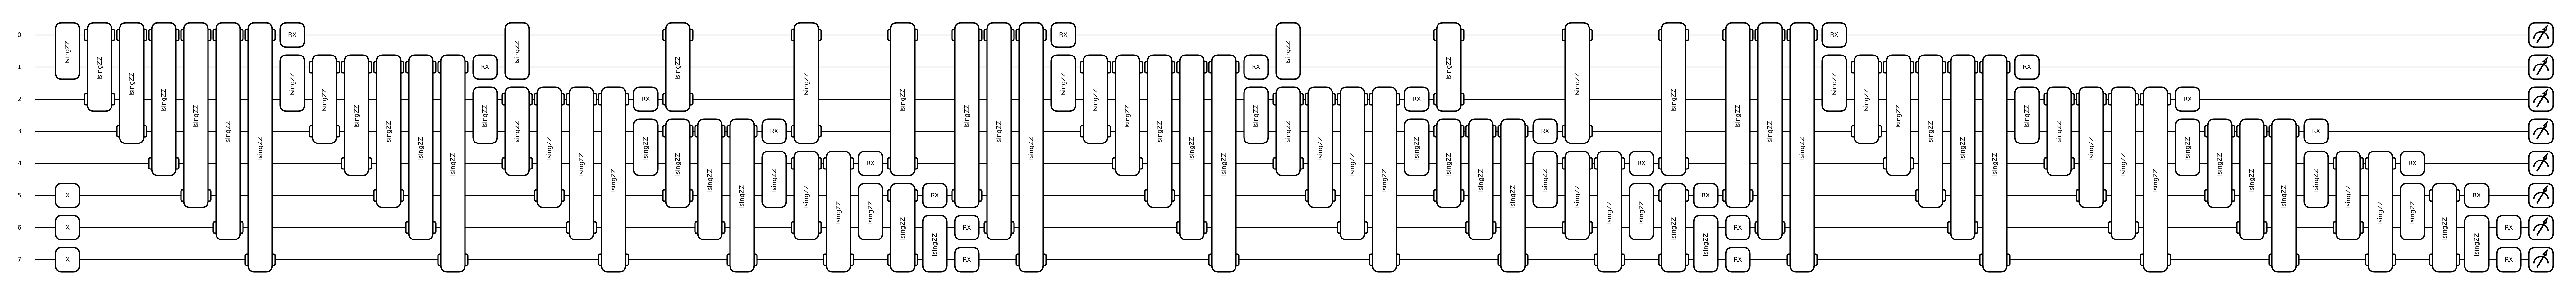

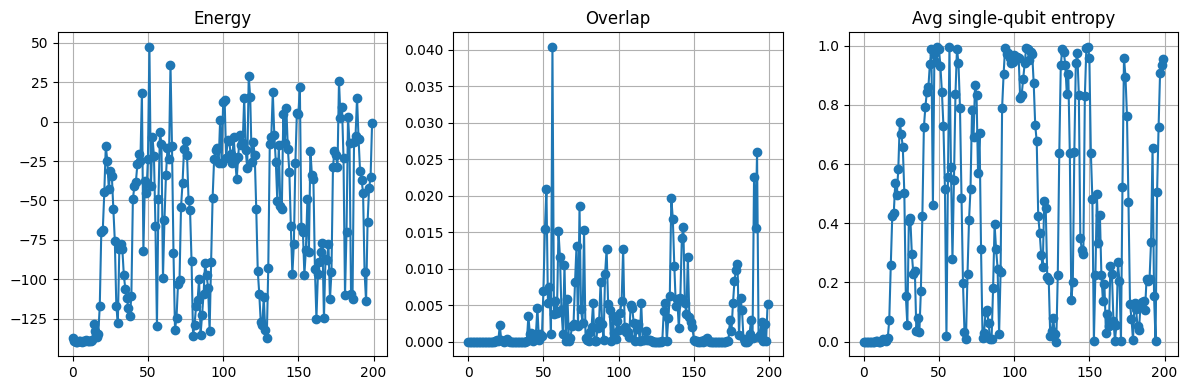

In [ ]:
# qaoa_pennylane_sim_fixed.py
# Corrected full QAOA PennyLane + Torch simulation script
# - Brute force (if N <= BRUTE_FORCE_LIMIT)
# - Warm-start modes
# - QAOA p-layers
# - Training with Adam + gradient clipping
# - ASCII circuit drawing + Matplotlib drawing & PNG save
# - Single-qubit von Neumann entropy (partial trace)
# - Multi-restart, save best params & history

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools, time, json, os
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict

# ---------------- User configuration ----------------
N = 8
d = 1.5
p = 3
max_iters = 200
patience = 60
save_dir = "./qaoa_sim_fixed_outputs"
os.makedirs(save_dir, exist_ok=True)

lr0 = 1e-2
grad_clip = 1.0
weight_decay = 0.0
num_restarts = 2
seed = 1234

start_mode = "classical"   # "classical" | "plus" | "blended"
blended_eps = 0.2

use_lightning = False
device_name = "lightning.qubit" if use_lightning else "default.qubit"
BRUTE_FORCE_LIMIT = 16

# Ensure torch dtype consistent
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)

# ---------------- Build J and edges ----------------
def build_J_and_edges(N: int, d: float) -> Tuple[np.ndarray, List[Tuple[int,int]], List[float]]:
    J = np.zeros((N, N), dtype=float)
    edges: List[Tuple[int,int]] = []
    weights: List[float] = []
    for i in range(N):
        for j in range(i+1, N):
            Jij = (i+1)**d + (j+1)**d
            J[i, j] = Jij
            J[j, i] = Jij
            edges.append((i, j))
            weights.append(float(Jij))
    return J, edges, weights

# ---------------- Brute force ground state ----------------
def classical_ground_state(N: int, d: float, limit: int = BRUTE_FORCE_LIMIT) -> Tuple[Optional[float], Optional[np.ndarray]]:
    if N > limit:
        return None, None
    best_E = float("inf")
    best_config = None
    for bits in itertools.product([1, -1], repeat=N):
        s = np.array(bits, dtype=float)
        # compute energy
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * s[i] * s[j]
        if E < best_E:
            best_E = E
            best_config = s.copy()
    return float(best_E), best_config

# ---------------- Device ----------------
try:
    dev = qml.device(device_name, wires=N)
except Exception as e:
    print(f"[Warning] could not instantiate {device_name}: {e}. Falling back to default.qubit")
    dev = qml.device("default.qubit", wires=N)

# ---------------- State preparation ----------------
def prepare_classical_state(s: np.ndarray):
    for i, val in enumerate(s):
        if float(val) < 0:
            qml.PauliX(wires=i)

def prepare_plus_state(N_local: int):
    for i in range(N_local):
        qml.Hadamard(wires=i)

def prepare_blended_state(s: np.ndarray, eps: float):
    # heuristic blended start: |+> then small Z rotations conditioned by s sign
    for i in range(len(s)):
        qml.Hadamard(wires=i)
    for i, val in enumerate(s):
        if float(val) < 0:
            qml.RZ(2.0 * eps, wires=i)

# ---------------- QAOA building blocks ----------------
def qaoa_cost_layer_edges(gamma, edges: List[Tuple[int,int]], weights: List[float]):
    for (i, j), w in zip(edges, weights):
        theta = 2.0 * gamma * float(w)
        qml.IsingZZ(theta, wires=[i, j])

def qaoa_mixer_layer(beta):
    for i in range(N):
        qml.RX(2.0 * beta, wires=i)

def build_hamiltonian_from_edges(edges: List[Tuple[int,int]], weights: List[float]) -> qml.Hamiltonian:
    coeffs = [float(w) for w in weights]
    ops = [qml.PauliZ(i) @ qml.PauliZ(j) for (i, j) in edges]
    return qml.Hamiltonian(coeffs, ops)

# ---------------- QNodes ----------------
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnode_energy(params, s_init, edges, weights, H):
    gammas = params[:p]
    betas  = params[p:]
    # prepare initial state
    if start_mode == "classical":
        prepare_classical_state(s_init)
    elif start_mode == "plus":
        prepare_plus_state(N)
    elif start_mode == "blended":
        prepare_blended_state(s_init, blended_eps)
    else:
        raise ValueError("Unknown start_mode")

    # layers
    for k in range(p):
        qaoa_cost_layer_edges(gammas[k], edges, weights)
        qaoa_mixer_layer(betas[k])

    return qml.expval(H)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnode_state_and_probs(params, s_init, edges, weights, H):
    gammas = params[:p]
    betas  = params[p:]
    if start_mode == "classical":
        prepare_classical_state(s_init)
    elif start_mode == "plus":
        prepare_plus_state(N)
    elif start_mode == "blended":
        prepare_blended_state(s_init, blended_eps)

    for k in range(p):
        qaoa_cost_layer_edges(gammas[k], edges, weights)
        qaoa_mixer_layer(betas[k])

    return qml.state(), qml.probs(wires=range(N))

# ---------------- helpers ----------------
def s_to_index(s: np.ndarray) -> int:
    bits = [0 if int(x) == 1 else 1 for x in s[::-1]]  # little-endian mapping
    idx = 0
    for b in bits:
        idx = (idx << 1) | b
    return idx

def compute_overlap_from_probs(probs_torch, s_idx: int) -> float:
    return float(probs_torch[s_idx].item())

def partial_trace_single_qubit(state_vec: np.ndarray, qubit: int, N_local: int) -> np.ndarray:
    # state_vec is vector of length 2**N_local
    psi = state_vec.reshape((-1, 1))
    rho = psi @ psi.conj().T  # full density matrix
    # Reshape to (2,)*2N tensor then trace out all but qubit
    resh = rho.reshape([2] * (2 * N_local))
    # axes permutation to bring qubit to front
    keep = [qubit]
    trace_axes = [i for i in range(N_local) if i not in keep]
    axes = keep + trace_axes + [i + N_local for i in keep] + [i + N_local for i in trace_axes]
    trans = np.transpose(resh, axes)
    k = len(keep)
    kept_dim = 2 ** k
    traced_dim = 2 ** (N_local - k)
    new_shape = (kept_dim, traced_dim, kept_dim, traced_dim)
    mat2 = trans.reshape(new_shape)
    res = np.zeros((kept_dim, kept_dim), dtype=complex)
    for a in range(traced_dim):
        res += mat2[:, a, :, a]
    return res

def single_qubit_entropy_from_state(state_np: np.ndarray, qubit_index: int, N_local: int) -> float:
    rho_red = partial_trace_single_qubit(state_np, qubit_index, N_local)
    eigs = np.linalg.eigvalsh(rho_red)
    eigs = np.clip(eigs.real, 0.0, 1.0)
    eps = 1e-12
    return float(-np.sum(eigs * np.log2(eigs + eps)))

def update_lr(lr: float, overlap: float) -> float:
    if overlap < 0.01:
        lr *= 1.25
    elif overlap < 0.1:
        lr *= 1.05
    elif overlap < 0.5:
        lr *= 0.95
    else:
        lr *= 0.8
    return min(max(lr, 1e-6), 1.0)

# ---------------- training (single run) ----------------
def run_one_training(seed_run: int = 0) -> Dict:
    torch.manual_seed(seed_run)
    np.random.seed(seed_run)

    J, edges, weights = build_J_and_edges(N, d)
    H = build_hamiltonian_from_edges(edges, weights)

    E_classical, s_star = classical_ground_state(N, d)
    s_idx = s_to_index(s_star) if s_star is not None else None

    # initial params length 2*p
    Jmax = np.max(np.abs(J)) if J.size > 0 else 1.0
    gamma0 = 0.05 / (Jmax if Jmax > 0 else 1.0)
    beta0 = 0.02
    init = np.array([gamma0] * p + [beta0] * p, dtype=float)
    params = torch.tensor(init, dtype=TORCH_DTYPE, requires_grad=True)

    optimizer = torch.optim.Adam([params], lr=lr0, weight_decay=weight_decay)
    lr = lr0

    best = {"energy": float("inf"), "overlap": 0.0, "entropy": None, "params": None}
    history = []
    no_improve = 0

    # prepare torch s_init
    s_star_torch = torch.tensor(s_star, dtype=TORCH_DTYPE)

    t0 = time.time()
    for it in range(max_iters):
        optimizer.zero_grad()
        energy_t = qnode_energy(params, s_star_torch, edges, weights, H)
        loss = energy_t
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_([params], grad_clip)

        optimizer.step()

        # diagnostics
        state_t, probs_t = qnode_state_and_probs(params, s_star_torch, edges, weights, H)
        overlap = compute_overlap_from_probs(probs_t, s_idx) if s_idx is not None else 0.0

        lr = update_lr(lr, overlap)
        for g in optimizer.param_groups:
            g['lr'] = lr

        state_np = state_t.detach().cpu().numpy()
        entropies = [single_qubit_entropy_from_state(state_np, q, N) for q in range(N)]
        avg_entropy = float(np.mean(entropies))

        energy_val = float(energy_t.detach().item())
        history.append({"iter": it, "energy": energy_val, "overlap": overlap, "lr": lr, "avg_entropy": avg_entropy})

        if energy_val < best["energy"] - 1e-12 or (abs(energy_val - best["energy"]) < 1e-12 and overlap > best["overlap"]):
            best.update({"energy": energy_val, "overlap": overlap, "entropy": avg_entropy, "params": params.clone().detach().cpu().numpy().tolist()})
            no_improve = 0
        else:
            no_improve += 1

        if it % 10 == 0 or it == max_iters - 1:
            print(f"[run {seed_run}] it {it:4d}  E={energy_val:.8f}  ov={overlap:.6f}  lr={lr:.4f}  avgS={avg_entropy:.4f}")

        if no_improve >= patience:
            lr *= 0.5
            for g in optimizer.param_groups:
                g['lr'] = lr
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_improve = 0
            print(f"[run {seed_run}] stagnation -> lr {lr:.3e}, perturbed params")

        if E_classical is not None and abs(energy_val - E_classical) < 1e-9:
            print(f"[run {seed_run}] reached classical energy at iter {it}")
            break

    t1 = time.time()
    print(f"[run {seed_run}] finished in {t1-t0:.2f}s")
    return {"best": best, "history": history, "J": J.tolist(), "edges": edges, "weights": weights, "classical_energy": E_classical, "classical_config": s_star.tolist() if s_star is not None else None}

# ---------------- circuit drawing helpers ----------------
def draw_circuit_ascii(params, s_init, edges, weights, H):
    # qml.draw returns a function that prints ASCII when called
    drawer = qml.draw(qnode_energy)
    print("\n========== ASCII CIRCUIT ==========\n")
    print(drawer(params, s_init, edges, weights, H))

def draw_circuit_mpl(params, s_init, edges, weights, H, save_path: Optional[str] = None):
    try:
        mpl_draw = qml.draw_mpl(qnode_energy)
        fig = mpl_draw(params, s_init, edges, weights, H)
        if save_path is not None:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"[✓] saved circuit image -> {save_path}")
        plt.show()
    except Exception as e:
        print("[Warning] draw_mpl failed:", e)

# ---------------- run with restarts ----------------
def run_with_restarts():
    runs = []
    global_best = None
    for r in range(num_restarts):
        seed_run = seed + r*13
        print(f"\n=== START RUN {r} (seed={seed_run}) ===")
        res = run_one_training(seed_run)
        runs.append(res)
        if global_best is None or res["best"]["energy"] < global_best["best"]["energy"] - 1e-12:
            global_best = {"run_index": r, "best": res["best"], "res": res}
    # save
    out = {"meta": {"N": N, "d": d, "p": p, "max_iters": max_iters, "num_restarts": num_restarts, "start_mode": start_mode}, "global_best": global_best, "runs": runs}
    fname = os.path.join(save_dir, "results_fixed.json")
    with open(fname, "w") as f:
        json.dump(out, f, indent=2)
    # save torch params
    if global_best and global_best["best"].get("params") is not None:
        params_np = np.array(global_best["best"]["params"])
        torch.save(torch.tensor(params_np, dtype=TORCH_DTYPE), os.path.join(save_dir, "best_params_fixed.pt"))
    print(f"Saved results -> {fname}")
    return out

# ---------------- main ----------------
if __name__ == "__main__":
    final = run_with_restarts()
    gb = final["global_best"]
    run_idx = gb["run_index"]
    res = gb["res"]
    best_params = np.array(gb["best"]["params"])
    s_best = res["classical_config"]
    edges = res["edges"]
    weights = res["weights"]
    H = build_hamiltonian_from_edges(edges, weights)

    # ASCII draw
    draw_circuit_ascii(best_params, torch.tensor(s_best, dtype=TORCH_DTYPE), edges, weights, H)

    # mpl draw + save
    out_png = os.path.join(save_dir, "best_circuit.png")
    draw_circuit_mpl(best_params, torch.tensor(s_best, dtype=TORCH_DTYPE), edges, weights, H, save_path=out_png)

    # quick plots of best run history
    hist = res["history"]
    its = [h["iter"] for h in hist]
    Es = [h["energy"] for h in hist]
    Ovs = [h["overlap"] for h in hist]
    Ss = [h["avg_entropy"] for h in hist]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.plot(its, Es, '-o'); plt.title("Energy"); plt.grid(True)
    plt.subplot(1,3,2); plt.plot(its, Ovs, '-o'); plt.title("Overlap"); plt.grid(True)
    plt.subplot(1,3,3); plt.plot(its, Ss, '-o'); plt.title("Avg single-qubit entropy"); plt.grid(True)
    plt.tight_layout()
    plt.show()


**CLEAN PENNYLANE + TORCH QAOA (NO WARM-START)**

Computing classical ground state...
Classical E: -139.32892446141048
Classical config: [ 1.  1.  1.  1.  1. -1. -1. -1.]

=== START RUN 0 (seed= 1234 ) ===
[1234] it   0 | E=1.452352 | ov=0.00877 | λ=1.9900
[1234] it  10 | E=-1.293452 | ov=0.00385 | λ=1.8927
[1234] it  20 | E=-0.967753 | ov=0.00356 | λ=1.8002
[1234] it  30 | E=0.174249 | ov=0.00720 | λ=1.7122
[1234] it  40 | E=0.040439 | ov=0.00092 | λ=1.6285
[1234] it  50 | E=-2.355644 | ov=0.00233 | λ=1.5488
[1234] it  60 | E=-1.124382 | ov=0.00481 | λ=1.4731
[1234] it  70 | E=-4.654932 | ov=0.00320 | λ=1.4011
[1234] it  80 | E=-5.600012 | ov=0.00357 | λ=1.3326
[1234] it  90 | E=-11.072965 | ov=0.00520 | λ=1.2674
[1234] it 100 | E=-15.009066 | ov=0.00438 | λ=1.2055
[1234] it 110 | E=-21.872453 | ov=0.00135 | λ=1.1465
[1234] it 120 | E=-26.667693 | ov=0.00274 | λ=1.0905
[1234] it 130 | E=-25.363269 | ov=0.00063 | λ=1.0372
[1234] it 140 | E=-28.211836 | ov=0.00293 | λ=0.9865
[1234] it 150 | E=-31.302133 | ov=0.00051 | λ=0.9382
[1234] i

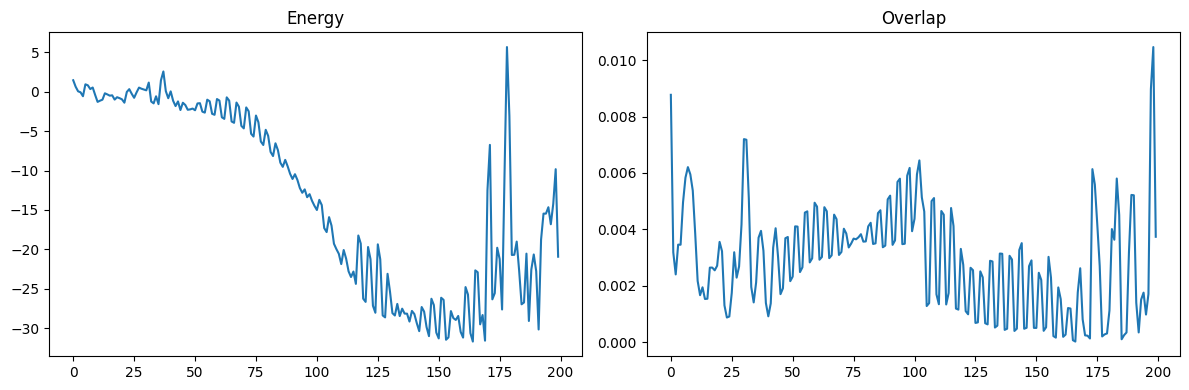

In [ ]:
# ================================================================
#
#   Classical solution used ONLY inside optimizer (λ guidance)
#   No state returned in differentiable QNodes
#   Fully stable & gradient-safe
# ================================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools
import os, time, json
import matplotlib.pyplot as plt

# ---------------- USER PARAMS ----------------
N = 8
d = 1.5
p = 3
max_iters = 200
patience = 40
num_restarts = 2
seed = 1234
save_dir = "./qaoa_guided_clean"
os.makedirs(save_dir, exist_ok=True)

# adaptive loss weights
lambda0 = 2.0
lambda_decay = 0.995
grad_clip = 1.0
lr0 = 0.02

BRUTE_FORCE_LIMIT = 16

device = qml.device("default.qubit", wires=N)


# ================================================================
# Classical brute-force ground state
# ================================================================
def classical_ground_state(N, d):
    if N > BRUTE_FORCE_LIMIT:
        raise RuntimeError("Too large for brute force")
    best_E = np.inf
    best_config = None
    for conf in itertools.product([1, -1], repeat=N):
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * conf[i] * conf[j]
        if E < best_E:
            best_E = E
            best_config = np.array(conf, float)
    return best_E, best_config


# ================================================================
# Build Hamiltonian edges
# ================================================================
def build_edges(N, d):
    edges = []
    weights = []
    for i in range(N):
        for j in range(i+1, N):
            edges.append((i, j))
            weights.append((i+1)**d + (j+1)**d)
    return edges, weights


def build_H(edges, weights):
    ops = [qml.PauliZ(i) @ qml.PauliZ(j) for (i,j) in edges]
    coeffs = [float(w) for w in weights]
    return qml.Hamiltonian(coeffs, ops)


# ================================================================
# QAOA layers
# ================================================================
def layer_cost(gamma, edges, weights):
    for (i, j), w in zip(edges, weights):
        qml.IsingZZ(2 * gamma * w, wires=[i, j])

def layer_mixer(beta):
    for i in range(N):
        qml.RX(2 * beta, wires=i)


# ================================================================
# Differentiable QNode (energy + probs)
# ================================================================
@qml.qnode(device, interface="torch", diff_method="parameter-shift")
def qnode_energy_probs(params, edges, weights, H):
    gammas = params[:p]
    betas = params[p:]

    # Start |++++...>
    for i in range(N):
        qml.Hadamard(wires=i)

    # QAOA layers
    for k in range(p):
        layer_cost(gammas[k], edges, weights)
        layer_mixer(betas[k])

    # returns both energy and probs → both differentiable
    return qml.expval(H), qml.probs(wires=range(N))


# ================================================================
# Non-diff QNode (state only for analysis)
# ================================================================
@qml.qnode(device, interface=None, diff_method=None)
def qnode_state_nodiff(params, edges, weights):
    gammas = params[:p]
    betas = params[p:]

    for i in range(N):
        qml.Hadamard(wires=i)

    for k in range(p):
        layer_cost(gammas[k], edges, weights)
        layer_mixer(betas[k])

    return qml.state()


# ================================================================
# Helpers
# ================================================================
def config_to_index(s):
    bits = [0 if int(x)==1 else 1 for x in s[::-1]]
    idx = 0
    for b in bits:
        idx = (idx << 1) | b
    return idx


# ================================================================
# Training routine (one restart)
# ================================================================
def train_one_run(run_seed, edges, weights, H, E_classical, s_star_idx):

    torch.manual_seed(run_seed)
    np.random.seed(run_seed)

    # initial parameters
    init = np.array([0.1]*p + [0.05]*p)
    params = torch.tensor(init, dtype=torch.float64, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr0)

    best = {"E": 1e9, "ov": 0.0, "params": None}
    history = []
    no_imp = 0
    lambda_t = lambda0

    for it in range(max_iters):

        optimizer.zero_grad()
        energy_t, probs_t = qnode_energy_probs(params, edges, weights, H)

        ov_t = probs_t[s_star_idx]
        loss = energy_t - lambda_t * ov_t

        loss.backward()

        torch.nn.utils.clip_grad_norm_([params], grad_clip)
        optimizer.step()

        # decay λ
        lambda_t *= lambda_decay

        E_val = float(energy_t.detach().item())
        ov_val = float(ov_t.detach().item())

        history.append({"iter": it, "energy": E_val, "overlap": ov_val})

        if E_val < best["E"]:
            best = {"E": E_val, "ov": ov_val, "params": params.detach().clone().numpy().tolist()}
            no_imp = 0
        else:
            no_imp += 1

        if it % 10 == 0:
            print(f"[{run_seed}] it {it:3d} | E={E_val:.6f} | ov={ov_val:.5f} | λ={lambda_t:.4f}")

        if abs(E_val - E_classical) < 1e-9:
            print(f"[{run_seed}] reached classical optimum.")
            break

        if no_imp >= patience:
            print(f"[{run_seed}] stagnation, reducing LR / perturbing")
            no_imp = 0
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)

    return best, history


# ================================================================
# Multi restart manager
# ================================================================
def run_with_restarts():

    print("Computing classical ground state...")
    E_classical, s_star = classical_ground_state(N, d)
    print("Classical E:", E_classical)
    print("Classical config:", s_star)

    s_idx = config_to_index(s_star)

    edges, weights = build_edges(N, d)
    H = build_H(edges, weights)

    global_best = {"E": 1e9, "params": None}
    all_runs = []

    for r in range(num_restarts):
        seed_run = seed + 100*r
        print("\n=== START RUN", r, "(seed=", seed_run, ") ===")
        best, hist = train_one_run(seed_run, edges, weights, H, E_classical, s_idx)
        all_runs.append({"best": best, "history": hist})
        if best["E"] < global_best["E"]:
            global_best = best

    return {"global_best": global_best, "runs": all_runs, "E_classical": E_classical, "s_star": s_star}


# ================================================================
# MAIN
# ================================================================
if __name__ == "__main__":

    result = run_with_restarts()
    gb = result["global_best"]

    print("\n--- GLOBAL BEST ---")
    print("Energy:", gb["E"])
    print("Overlap:", gb["ov"])
    print("Params:", gb["params"])

    # Plot best run
    best_hist = result["runs"][0]["history"]
    its = [h["iter"] for h in best_hist]
    Es  = [h["energy"] for h in best_hist]
    Ovs = [h["overlap"] for h in best_hist]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(its, Es); plt.title("Energy")
    plt.subplot(1,2,2); plt.plot(its, Ovs); plt.title("Overlap")
    plt.tight_layout()
    plt.show()


fast classical method instade of brute forcing

In [ ]:
#def fast_classical_ground_state(N, d, BRUTE_FORCE_LIMIT=20):

import numpy as np


N=13
d=1.5

# prefix sums A(k) = sum_{i=1}^k i^d
ranks = np.arange(1, N+1, dtype=float)
powers = np.power(ranks, d)
P = np.cumsum(powers)

best_E = np.inf
best_M = 0

for M in range(N + 1):
    A_M = P[M-1] if M > 0 else 0.0
    A_N = P[N-1]
    S = 2 * M - N
    D = 2 * A_M - A_N
    E = S * D - A_N

    if E < best_E:
        best_E = E
        best_M = M

config = np.array([1.0] * best_M + [-1.0] * (N - best_M))

print( best_E, config)

-566.0890728989675 [ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.]


**PENNYLANE + TORCH QAOA WITH PARAM WARM-START**

In [ ]:
# ================================================================
#
#   Warm-start params taken from user's best previous solution
# ================================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools
import os, time, json
import matplotlib.pyplot as plt

# ---------------- USER PARAMS ----------------
N = 8
d = 1.5
p = 3
max_iters = 200
patience = 40
num_restarts = 1
seed = 1234
save_dir = "./qaoa_guided_paramwarm"
os.makedirs(save_dir, exist_ok=True)

# adaptive loss weights
lambda0 = 2.0
lambda_decay = 0.995
grad_clip = 1.0
lr0 = 0.02

BRUTE_FORCE_LIMIT = 16

device = qml.device("default.qubit", wires=N)

# ================================================================
# WARM-START PARAMETERS (YOUR VALUES)
# ================================================================
warm_params_np = np.array([
    0.08985005133795804,
    0.17690138550424236,
    0.11169227205395954,
    0.24940059442417403,
    -0.6290277637253829,
    0.3321480828180494
], dtype=float)

assert len(warm_params_np) == 2*p, "Length mismatch: warm-start params must be 2*p"


# ================================================================
# Classical brute-force ground state
# ================================================================
def classical_ground_state(N, d):
    if N > BRUTE_FORCE_LIMIT:
        raise RuntimeError("Too large for brute force")
    best_E = np.inf
    best_config = None
    for conf in itertools.product([1, -1], repeat=N):
        E = 0.0
        for i in range(N):
            for j in range(i+1, N):
                E += ((i+1)**d + (j+1)**d) * conf[i] * conf[j]
        if E < best_E:
            best_E = E
            best_config = np.array(conf, float)
    return best_E, best_config


# ================================================================
# Build graph Hamiltonian
# ================================================================
def build_edges(N, d):
    edges = []
    weights = []
    for i in range(N):
        for j in range(i+1, N):
            edges.append((i, j))
            weights.append((i+1)**d + (j+1)**d)
    return edges, weights


def build_H(edges, weights):
    ops = [qml.PauliZ(i) @ qml.PauliZ(j) for (i,j) in edges]
    coeffs = [float(w) for w in weights]
    return qml.Hamiltonian(coeffs, ops)


# ================================================================
# QAOA Layers
# ================================================================
def layer_cost(gamma, edges, weights):
    for (i,j), w in zip(edges, weights):
        qml.IsingZZ(2 * gamma * w, wires=[i,j])

def layer_mixer(beta):
    for i in range(N):
        qml.RX(2 * beta, wires=i)


# ================================================================
# Differentiable QNode (E + probs)
# ================================================================
@qml.qnode(device, interface="torch", diff_method="parameter-shift")
def qnode_energy_probs(params, edges, weights, H):

    gammas = params[:p]
    betas  = params[p:]

    for i in range(N):
        qml.Hadamard(wires=i)

    for k in range(p):
        layer_cost(gammas[k], edges, weights)
        layer_mixer(betas[k])

    return qml.expval(H), qml.probs(wires=range(N))


# ================================================================
# NON-diff state QNode
# ================================================================
@qml.qnode(device, interface=None, diff_method=None)
def qnode_state_nodiff(params, edges, weights):

    gammas = params[:p]
    betas  = params[p:]

    for i in range(N):
        qml.Hadamard(wires=i)

    for k in range(p):
        layer_cost(gammas[k], edges, weights)
        layer_mixer(betas[k])

    return qml.state()


# ================================================================
# Helpers
# ================================================================
def config_to_index(s):
    bits = [0 if int(x)==1 else 1 for x in s[::-1]]
    idx = 0
    for b in bits:
        idx = (idx<<1) | b
    return idx


# ================================================================
# Training with param warm-start
# ================================================================
def train_with_param_warmstart(edges, weights, H, E_classical, s_star_idx):

    torch.manual_seed(seed)
    np.random.seed(seed)

    # ----------------------------
    # WARM-START PARAMETERS HERE
    # ----------------------------
    params = torch.tensor(
        warm_params_np.copy(),
        dtype=torch.float64,
        requires_grad=True
    )

    optimizer = torch.optim.Adam([params], lr=lr0)

    best = {"E": 1e9, "ov": 0.0, "params": None}
    history = []
    no_imp = 0
    lambda_t = lambda0

    for it in range(max_iters):

        optimizer.zero_grad()
        energy_t, probs_t = qnode_energy_probs(params, edges, weights, H)

        ov_t = probs_t[s_star_idx]
        loss = energy_t - lambda_t * ov_t

        loss.backward()

        torch.nn.utils.clip_grad_norm_([params], grad_clip)
        optimizer.step()

        lambda_t *= lambda_decay

        E_val = float(energy_t.detach().item())
        ov_val = float(ov_t.detach().item())

        history.append({"iter": it, "energy": E_val, "overlap": ov_val})

        if E_val < best["E"]:
            best = {"E": E_val, "ov": ov_val,
                    "params": params.detach().clone().numpy().tolist()}
            no_imp = 0
        else:
            no_imp += 1

        if it % 10 == 0:
            print(f"[warm] it {it:3d} | E={E_val:.6f} | ov={ov_val:.5f} | λ={lambda_t:.4f}")

        if abs(E_val - E_classical) < 1e-9:
            print("[warm] reached classical optimum.")
            break

        if no_imp >= patience:
            print("[warm] stagnation → perturb")
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_imp = 0

    return best, history


# ================================================================
# MAIN
# ================================================================
if __name__ == "__main__":

    print("Computing classical solution...")
    E_cl, s_star = classical_ground_state(N, d)
    s_idx = config_to_index(s_star)

    edges, weights = build_edges(N, d)
    H = build_H(edges, weights)

    best, hist = train_with_param_warmstart(edges, weights, H, E_cl, s_idx)

    print("\n--- RESULT ---")
    print("Energy:", best["E"])
    print("Overlap:", best["ov"])
    print("Params:", best["params"])

    its = [h["iter"] for h in hist]
    Es  = [h["energy"] for h in hist]
    Ovs = [h["overlap"] for h in hist]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(its, Es); plt.title("Energy")
    plt.subplot(1,2,2); plt.plot(its, Ovs); plt.title("Overlap")
    plt.tight_layout()
    plt.show()


Computing classical solution...
[warm] it   0 | E=-22.669235 | ov=0.00007 | λ=1.9900
[warm] it  10 | E=-15.486892 | ov=0.00137 | λ=1.8927
[warm] it  20 | E=-37.011832 | ov=0.00077 | λ=1.8002
[warm] it  30 | E=-35.207904 | ov=0.00080 | λ=1.7122
[warm] it  40 | E=-36.832638 | ov=0.00025 | λ=1.6285
[warm] it  50 | E=-36.912092 | ov=0.00097 | λ=1.5488
[warm] it  60 | E=-34.672044 | ov=0.00017 | λ=1.4731
[warm] it  70 | E=-38.181485 | ov=0.00026 | λ=1.4011
[warm] it  80 | E=-36.729022 | ov=0.00001 | λ=1.3326
[warm] it  90 | E=-34.528684 | ov=0.00035 | λ=1.2674
[warm] it 100 | E=-36.703921 | ov=0.00011 | λ=1.2055
[warm] stagnation → perturb
[warm] it 110 | E=-36.824586 | ov=0.00050 | λ=1.1465


KeyboardInterrupt: 

**^^^interrupted**

[pure] it    0 | E=-22.6692349
[pure] it   10 | E=-14.8079077
[pure] it   20 | E=-36.3426542
[pure] it   30 | E=-32.0048354
[pure] it   40 | E=-33.7271602
[pure] it   50 | E=-30.9038971
[pure] it   60 | E=-34.1499035
[pure] stagnation → small perturbation
[pure] it   70 | E=-35.9112010
[pure] it   80 | E=-24.0740831
[pure] it   90 | E=-35.3979555
[pure] it  100 | E=-33.7202044
[pure] it  110 | E=-32.6373285
[pure] stagnation → small perturbation
[pure] it  120 | E=-29.6773961
[pure] it  130 | E=-34.6258105
[pure] it  140 | E=-27.4174307
[pure] it  150 | E=-36.8880666
[pure] stagnation → small perturbation
[pure] it  160 | E=-35.8768278
[pure] it  170 | E=-25.8146999
[pure] it  180 | E=-25.5782620
[pure] it  190 | E=-32.2334018
[pure] stagnation → small perturbation
[pure] it  200 | E=-35.6757440
[pure] it  210 | E=-34.1232751
[pure] it  220 | E=-36.2409815
[pure] it  230 | E=-37.6932085
[pure] it  240 | E=-27.8295569

--- FINAL RESULT ---
Final Energy: -37.803440642330756
Final Params:

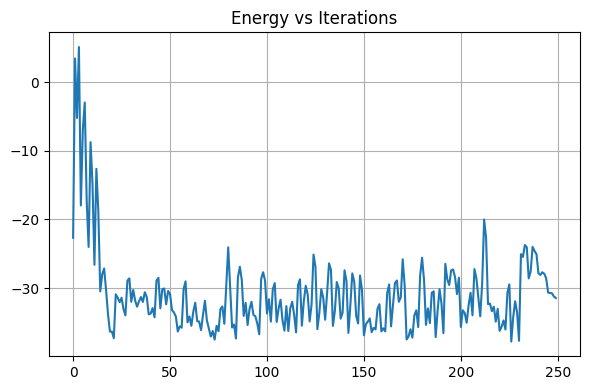

In [ ]:
# ================================================================
#   PURE QAOA WITH PARAMETER WARM-START (NO CLASSICAL SOLUTION), Parameters are from progress of the same ising Hamiltonian
# =========================================================================================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import itertools
import os, time, json
import matplotlib.pyplot as plt

# ---------------- USER PARAMS ----------------
N = 8
d = 1.5
p = 3
max_iters = 250
patience = 40
seed = 1234
save_dir = "./qaoa_paramwarm_pure"
os.makedirs(save_dir, exist_ok=True)

lr0 = 0.02
grad_clip = 1.0

device = qml.device("default.qubit", wires=N)

# ================================================================
# WARM-START PARAMETERS GIVEN BY YOU
# ================================================================
warm_params_np = np.array([
    0.08985005133795804,
    0.17690138550424236,
    0.11169227205395954,
    0.24940059442417403,
    -0.6290277637253829,
    0.3321480828180494
], dtype=float)

assert len(warm_params_np) == 2*p


# ================================================================
# Build QAOA Hamiltonian
# ================================================================
def build_edges(N, d):
    edges = []
    weights = []
    for i in range(N):
        for j in range(i+1, N):
            edges.append((i, j))
            weights.append((i+1)**d + (j+1)**d)
    return edges, weights

def build_H(edges, weights):
    ops = [qml.PauliZ(i) @ qml.PauliZ(j) for (i,j) in edges]
    coeffs = [float(w) for w in weights]
    return qml.Hamiltonian(coeffs, ops)


# ================================================================
# Layers
# ================================================================
def layer_cost(gamma, edges, weights):
    for (i,j), w in zip(edges, weights):
        qml.IsingZZ(2 * gamma * w, wires=[i,j])

def layer_mixer(beta):
    for i in range(N):
        qml.RX(2 * beta, wires=i)


# ================================================================
# QNode (Energy only, differentiable)
# ================================================================
@qml.qnode(device, interface="torch", diff_method="parameter-shift")
def qnode_energy(params, edges, weights, H):

    gammas = params[:p]
    betas  = params[p:]

    for i in range(N):
        qml.Hadamard(wires=i)

    for k in range(p):
        layer_cost(gammas[k], edges, weights)
        layer_mixer(betas[k])

    return qml.expval(H)


# ================================================================
# TRAINING (pure energy minimization)
# ================================================================
def run_training():

    torch.manual_seed(seed)
    np.random.seed(seed)

    edges, weights = build_edges(N, d)
    H = build_H(edges, weights)

    # -----------------------------
    # WARM-START PARAMETERS
    # -----------------------------
    params = torch.tensor(
        warm_params_np.copy(),
        dtype=torch.float64,
        requires_grad=True
    )

    optimizer = torch.optim.Adam([params], lr=lr0)

    best = {"E": 1e9, "params": None}
    history = []
    no_imp = 0

    for it in range(max_iters):

        optimizer.zero_grad()
        energy_t = qnode_energy(params, edges, weights, H)

        loss = energy_t
        loss.backward()

        torch.nn.utils.clip_grad_norm_([params], grad_clip)
        optimizer.step()

        E_val = float(energy_t.detach().item())
        history.append({"iter": it, "energy": E_val})

        if E_val < best["E"]:
            best = {"E": E_val,
                    "params": params.detach().clone().numpy().tolist()}
            no_imp = 0
        else:
            no_imp += 1

        if it % 10 == 0:
            print(f"[pure] it {it:4d} | E={E_val:.7f}")

        if no_imp >= patience:
            print("[pure] stagnation → small perturbation")
            with torch.no_grad():
                params.add_(torch.randn_like(params) * 1e-3)
            no_imp = 0

    return best, history, edges, weights, H


# ================================================================
# MAIN
# ================================================================
if __name__ == "__main__":

    best, hist, edges, weights, H = run_training()

    print("\n--- FINAL RESULT ---")
    print("Final Energy:", best["E"])
    print("Final Params:", best["params"])

    its = [h["iter"] for h in hist]
    Es  = [h["energy"] for h in hist]

    plt.figure(figsize=(6,4))
    plt.plot(its, Es)
    plt.title("Energy vs Iterations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import itertools
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam

# ============================================================
#                   Problem Definition
# ============================================================

def build_J(N, d):
    J = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            J[i, j] = (i+1)**d + (j+1)**d
            J[j, i] = J[i, j]
    return J


def build_hamiltonian(N, d):
    coeffs = []
    ops = []
    J = build_J(N, d)
    for i in range(N):
        for j in range(i+1, N):
            coeffs.append(J[i, j])
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    return qml.Hamiltonian(coeffs, ops), J


# ============================================================
#                  Brute Force Solver
# ============================================================

def brute_force_ground_state(N, J):
    best_E = 1e30
    best_config = None

    for bits in itertools.product([-1, 1], repeat=N):
        s = np.array(bits)
        E = np.sum(J * np.outer(s, s)) / 2
        if E < best_E:
            best_E = E
            best_config = s.copy()

    return best_E, best_config


# ============================================================
#                  QAOA Circuits
# ============================================================

def qaoa_layer(gamma, beta, J, N):
    for i in range(N):
        for j in range(i+1, N):
            qml.IsingZZ(2 * gamma * J[i,j], wires=[i,j])
    for q in range(N):
        qml.RX(2 * beta, wires=q)


def build_energy_qnode(N, p, dev, J, H, BRUTE_CONFIG):
    @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
    def circuit(params):
        gammas = params[:p]
        betas = params[p:]

        # Warm start
        for i in range(N):
            if BRUTE_CONFIG[i] == -1:
                qml.PauliX(i)

        # Layers
        for layer in range(p):
            qaoa_layer(gammas[layer], betas[layer], J, N)

        return qml.expval(H)

    return circuit


def build_state_qnode(N, p, dev, J, BRUTE_CONFIG):
    """Returns full statevector."""
    @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
    def circuit(params):
        gammas = params[:p]
        betas = params[p:]

        for i in range(N):
            if BRUTE_CONFIG[i] == -1:
                qml.PauliX(i)

        for layer in range(p):
            qaoa_layer(gammas[layer], betas[layer], J, N)

        return qml.state()

    return circuit


# ============================================================
#                            MAIN
# ============================================================

if __name__ == "__main__":
    N = 13
    d = 1.5
    p = 3

    print("\nBuilding Hamiltonian...")
    H, J = build_hamiltonian(N, d)

    print("Running brute-force search...")
    BRUTE_E, BRUTE_CONFIG = brute_force_ground_state(N, J)
    print("Brute Force Ground Energy:", BRUTE_E)
    print("Brute Force Config:", BRUTE_CONFIG)

    dev = qml.device("default.qubit", wires=N)

    qnode_energy = build_energy_qnode(N, p, dev, J, H, BRUTE_CONFIG)
    qnode_state = build_state_qnode(N, p, dev, J, BRUTE_CONFIG)

    params = torch.tensor(
        np.concatenate([0.1*np.ones(p), 0.05*np.ones(p)]),
        dtype=torch.float64,
        requires_grad=True
    )

    opt = Adam([params], lr=0.05)

    energy_history = []
    overlap_history = []

    # Build target index
    # +1 -> '0' , -1 -> '1'
    target_bits = ''.join('1' if x == -1 else '0' for x in BRUTE_CONFIG[::-1])
    target_idx = int(target_bits, 2)

    print("\nStarting QAOA training...\n")
    for it in range(120):

        opt.zero_grad()
        loss = qnode_energy(params)
        loss.backward()
        opt.step()

        energy = loss.item()
        energy_history.append(energy)

        if it % 5 == 0:
            state = qnode_state(params).detach().cpu().numpy()
            probs = np.abs(state)**2
            overlap = probs[target_idx]

            overlap_history.append(overlap)
            print(f"Iter {it:3d} | Energy = {energy:.6f} | Overlap = {overlap:.5f}")
        else:
            overlap_history.append(None)

    # -------------------- plots --------------------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(energy_history, '-o')
    plt.axhline(BRUTE_E, color='r', linestyle='--')
    plt.title("Energy")

    plt.subplot(1,2,2)
    plt.plot([x if x is not None else np.nan for x in overlap_history], '-o')
    plt.title("Overlap with classical ground state")

    plt.tight_layout()
    plt.show()

    print("\nFinal Energy:", energy_history[-1])
    print("Brute-force optimal energy:", BRUTE_E)



Building Hamiltonian...
Running brute-force search...
Brute Force Ground Energy: -566.0890728989673
Brute Force Config: [-1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1]

Starting QAOA training...

Iter   0 | Energy = -547.257870 | Overlap = 0.00000


KeyboardInterrupt: 

In [ ]:
# qaoa_ibm_spsa_run_precise.py
# Run QAOA (same Ising as user's) on IBM Runtime using SPSA.
# N=13, d=1.5 example with provided classical solution.
# - sanity-checks on local Aer simulator before submitting to runtime
# - logs every objective evaluation
# - saves best params (.json + .pt) and plots traces

import os, time, json, math
from typing import List, Tuple
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
from qiskit.algorithms.optimizers import SPSA

# plotting & tensor save
import matplotlib.pyplot as plt
import torch

# ---------------- User / runtime settings ----------------
SERVICE_CHANNEL = "ibm_quantum"        # saved service channel name
BACKEND_RUNTIME = "ibmq_qasm_simulator"  # replace with actual runtime backend (e.g., "ibm_perth")
SHOTS = 4000
MAX_SPSA_ITERS = 150
SEED = 42

# Problem settings (use exact Ising you gave)
N = 13
d = 1.5
p = 3

# Classical solution you provided (we'll use it for warm start and sanity checks)
CLASSICAL_ENERGY = -566.0890728989674
CLASSICAL_CONFIG = [1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1]  # length N

# Output dir
OUT_DIR = "./ibm_qaoa_precise_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Safety: run a local Aer sanity check before launching to hardware
RUN_LOCAL_SANITY = True   # set False to skip local sim (not recommended)
AER_SHOTS = 2000

# Optional: if you already have best params from simulation (warm start on HW), put them here (list length 2*p)
INITIAL_PARAMS_FROM_SIM = None  # e.g. [g0,...,gp-1,b0,...,bp-1] or None

# ---------------- Helpers: build J, edges, weights ----------------
def build_J_and_edges(N: int, d: float):
    J = np.zeros((N,N), dtype=float)
    edges = []
    weights = []
    for i in range(N):
        for j in range(i+1, N):
            Jij = (i+1)**d + (j+1)**d
            J[i,j] = Jij
            J[j,i] = Jij
            edges.append((i,j))
            weights.append(float(Jij))
    return J, edges, weights

# ---------------- Build Qiskit parameterized QAOA circuit ----------------
def build_param_qaoa_circuit(N:int, p:int, edges:List[Tuple[int,int]], weights:List[float], start_mode:str="classical", s_star:List[int]=None):
    params = [Parameter(f"g_{k}") for k in range(p)] + [Parameter(f"b_{k}") for k in range(p)]
    gammas = params[:p]
    betas = params[p:]

    qc = QuantumCircuit(N)

    # start state
    if start_mode == "classical" and s_star is not None:
        for i,val in enumerate(s_star):
            if int(val) < 0:
                qc.x(i)
    elif start_mode == "plus":
        for i in range(N):
            qc.h(i)
    else:
        for i in range(N):
            qc.h(i)

    # Layers
    for layer in range(p):
        gamma = gammas[layer]
        # implement IsingZZ: CX - RZ(theta) - CX with theta = 2 * gamma * J_ij
        for (i,j), w in zip(edges, weights):
            theta = 2 * gamma * w  # symbolic Parameter * float -> ParameterExpression
            qc.cx(i, j)
            qc.rz(theta, j)
            qc.cx(i, j)
        # mixer
        beta = betas[layer]
        for q in range(N):
            qc.rx(2 * beta, q)

    return qc, params

# ---------------- Build SparsePauliOp for H = sum_{i<j} J_ij Z_i Z_j ----------------
def build_sparse_pauli_for_H(N:int, edges:List[Tuple[int,int]], weights:List[float]):
    pauli_list = []
    for (i,j), w in zip(edges, weights):
        # Build pauli string with qubit 0 as leftmost character in the string for readability,
        # but Qiskit Pauli() expects string with qubit 0 as least-significant (rightmost).
        # To avoid confusion, we construct with rightmost = qubit 0.
        s = ['I'] * N
        s[i] = 'Z'
        s[j] = 'Z'
        # Now create string with qubit0 at rightmost -> reverse the list
        pauli_str = ''.join(s[::-1])
        pauli_list.append((pauli_str, w))
    op = SparsePauliOp.from_list(pauli_list)
    return op

# ---------------- Estimator objective with logging ----------------
def make_estimator_objective(service:QiskitRuntimeService, backend:str, qc_template:QuantumCircuit, params_objects, observable:SparsePauliOp, shots:int=4000, record_list=None):
    estimator = Estimator(session=service)
    options = Options()
    options.execution.shots = shots
    # options.execution.resilience_level = 0

    def objective(x_np: np.ndarray) -> float:
        # bind params
        bind_map = {}
        for k in range(p):
            bind_map[params_objects[k]] = float(x_np[k])
        for k in range(p):
            bind_map[params_objects[p+k]] = float(x_np[p+k])
        bound_qc = qc_template.bind_parameters(bind_map)

        # run estimator (this is a synchronous call)
        job = estimator.run(circuits=[bound_qc], observables=[observable], backend=backend, options=options)
        result = job.result()
        val = float(result.values[0])
        # log
        if record_list is not None:
            record_list.append({"params": x_np.tolist(), "energy": val, "time": time.time()})
        return val

    return objective

# ---------------- Local Aer-based sanity check (expectation + overlap check) ----------------
def local_sanity_check(qc_template:QuantumCircuit, params_objects, observable:SparsePauliOp, edges, weights, s_star, params_test, shots=AER_SHOTS):
    # Bind window and simulate with statevector and with shots
    bound = qc_template.bind_parameters(params_test)
    # statevector backend
    sv_sim = Aer.get_backend("aer_simulator_statevector")
    psi = sv_sim.run(bound).result().get_statevector()
    # compute expectation via Pauli op on statevector
    # Note: SparsePauliOp expects little-endian ordering for strings; Qiskit statevector uses same ordering.
    exp_val = observable.expectation_value(psi).real
    # also sample counts with Aer qasm_simulator
    qasm = Aer.get_backend("aer_simulator")
    tqc = transpile(bound, qasm)
    res = qasm.run(tqc, shots=shots).result()
    counts = res.get_counts()
    # probability of s_star (convert bitstring)
    # note: counts keys are bitstrings with qubit 0 as leftmost? Qiskit uses bitstring with qubit N-1 as leftmost in counts
    # mapping: our s_star -> bitstring with qubit N-1 ... 0 (left to right)
    bit = ''.join(['0' if int(x)==1 else '1' for x in s_star[::-1]])  # rightmost qubit=0
    prob = counts.get(bit, 0)/shots
    return float(exp_val), float(prob), psi

# ---------------- Main runner ----------------
def run_ibm_qaoa_spsa():
    print("Building J and circuit templates...")
    J, edges, weights = build_J_and_edges(N, d)

    # build parameterized circuit
    qc_template, params_objects = build_param_qaoa_circuit(N, p, edges, weights, start_mode="classical", s_star=CLASSICAL_CONFIG)
    print("QAOA template depth:", qc_template.depth(), "num qubits:", N)

    # build observable
    observable = build_sparse_pauli_for_H(N, edges, weights)

    # local sanity check with initial guess
    if INITIAL_PARAMS_FROM_SIM is not None:
        x0 = np.array(INITIAL_PARAMS_FROM_SIM, dtype=float)
    else:
        Jmax = np.max(np.abs(J))
        gamma0 = 0.05 / (Jmax if Jmax>0 else 1.0)
        beta0 = 0.02
        x0 = np.array([gamma0]*p + [beta0]*p, dtype=float)

    print("Initial params (x0):", x0.tolist())

    if RUN_LOCAL_SANITY:
        print("Running local Aer sanity check (statevector + sampling)...")
        exp_val_local, prob_local, psi = local_sanity_check(qc_template, params_objects, observable, edges, weights, CLASSICAL_CONFIG, {params_objects[k]: float(x0[k]) for k in range(2*p)}, shots=AER_SHOTS)
        print("Local statevector expectation:", exp_val_local)
        print("Local sample prob(s*) :", prob_local)
        # check direction: energy should be >= classical ground energy (since warm-start maybe at ground)
        print("Classical ground energy (given):", CLASSICAL_ENERGY)
        # If expectation very close to classical energy (within numerical), okay.
        # If sign mismatch or large difference, warn user to check Pauli ordering.
        if abs(exp_val_local - CLASSICAL_ENERGY) > 1e-6 and abs(exp_val_local) > 1e-6:
            print("WARNING: local expectation differs from given classical energy by:", exp_val_local - CLASSICAL_ENERGY)
            print("If sign or mapping mismatch, you may need to adjust Pauli string endianness in build_sparse_pauli_for_H.")
            # do not abort — just warn

    # connect to IBM Runtime
    print("Connecting to Qiskit Runtime service...")
    service = QiskitRuntimeService(channel=SERVICE_CHANNEL)

    # set up logging list for objective evaluations
    eval_log = []

    # create objective wrapper
    objective = make_estimator_objective(service, BACKEND_RUNTIME, qc_template, params_objects, observable, shots=SHOTS, record_list=eval_log)

    # SPSA optimizer from qiskit
    spsa = SPSA(maxiter=MAX_SPSA_ITERS, perturbation=0.1, learning_rate=0.2, blocking=False, seed=SEED)

    print("Starting SPSA optimization on backend", BACKEND_RUNTIME, "with shots", SHOTS)
    start_time = time.time()
    res = spsa.optimize(num_vars=2*p, objective_function=objective, initial_point=x0)
    end_time = time.time()

    opt_x = res[0]
    opt_val = res[1]
    niters = res[2]
    print("SPSA done. iterations:", niters, "optimal energy:", opt_val)

    # save logs and results
    out = {
        "meta": {"N": N, "d": d, "p": p, "backend": BACKEND_RUNTIME, "shots": SHOTS, "spsa_maxiter": MAX_SPSA_ITERS},
        "classical": {"energy": CLASSICAL_ENERGY, "config": CLASSICAL_CONFIG},
        "initial_params": x0.tolist(),
        "opt_params": opt_x.tolist(),
        "opt_energy": float(opt_val),
        "niter": int(niters),
        "time_s": float(end_time - start_time),
        "eval_log": eval_log
    }
    fname = os.path.join(OUT_DIR, f"qaoa_ibm_spsa_N{N}_p{p}.json")
    with open(fname, "w") as f:
        json.dump(out, f, indent=2)
    print("Saved run results to", fname)

    # save best params as .pt
    pt_fname = os.path.join(OUT_DIR, f"best_params_N{N}_p{p}.pt")
    torch.save(torch.tensor(opt_x), pt_fname)
    print("Saved best params .pt ->", pt_fname)

    # plot energy trace from eval_log
    energies = [e["energy"] for e in eval_log]
    plt.figure(figsize=(8,4))
    plt.plot(energies, '-o', markersize=3)
    plt.axhline(CLASSICAL_ENERGY, color='r', linestyle='--', label='classical energy')
    plt.xlabel("Estimator calls")
    plt.ylabel("Energy")
    plt.title("Energy trace (Estimator evaluations)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"energy_trace_N{N}_p{p}.png"))
    plt.show()

    return out

# ---------------- run main ----------------
if __name__ == "__main__":
    result = run_ibm_qaoa_spsa()
    print("Result summary:", result["opt_energy"], "params saved to .pt")


In [ ]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.optimize import minimize_scalar

# Parameters
N = 1000  # Change to any N you want
np.random.seed(42)

# Generate or load mixed J (SK example)
J_original = np.random.normal(0, 1 / np.sqrt(N), (N, N))
J_original = (J_original + J_original.T) / 2
np.fill_diagonal(J_original, 0)

# Fiedler reordering
D = np.diag(np.abs(J_original).sum(axis=1))
L = D - np.abs(J_original)
vals, eigvecs = eigsh(L, k=2, which='SM')
fiedler = eigvecs[:, 1]
order = np.argsort(fiedler)
J_reordered = J_original[np.ix_(order, order)]

# Forced projection to pure RB
i, j = np.meshgrid(np.arange(1, N + 1), np.arange(1, N + 1))

def project(d):
    model = (i**d + j**d) / (N**d)
    np.fill_diagonal(model, 0)
    return model

def error(d):
    return np.linalg.norm(J_reordered - project(d), 'fro')

res = minimize_scalar(error, bounds=(-3, 5), method='bounded')
d_opt = res.x
J_RB = project(d_opt)

print(f"Optimal d: {d_opt:.4f}")
print(f"Projection error: {error(d_opt):.4f}")

# O(N) ground state
def F_d(x, d):
    return np.sum(np.arange(1, x + 1)**d)

H_M = [(N - 2 * M - 1) * F_d(N, d_opt) + (4 * M - 2 * N) * F_d(M, d_opt) / N**d_opt for M in range(1, N)]
min_M = np.argmin(H_M) + 1
E_ground = H_M[min_M - 1]

s_ground = np.ones(N)
s_ground[min_M:] = -1
flips = np.sum(np.diff(s_ground) != 0)

print(f"Ground M: {min_M}, E: {E_ground:.4f}, flips: {flips}")

# Inverse order for original spins
s_original = np.empty(N)
s_original[order] = s_ground

Optimal d: 5.0000
Projection error: 488.7645
Ground M: 999, E: -166995919630412087296.0000, flips: 1
